# Основы глубинного обучения, майнор ИАД

## Полносвязные нейронные сети.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torchvision
import pandas as pd
import numpy as np
import random
import torch.nn.functional as F
import warnings

from tqdm.notebook import tqdm
from tqdm.auto import tqdm
from IPython.display import clear_output

warnings.filterwarnings("ignore")

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!pip install wget

In [ ]:
# import wget 
# wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip', 'data.txt.zip')  # works locally

In [4]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip # doesnt work locally but works in collab

--2022-10-26 16:57:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  82.8MB/s    in 2.4s    

2022-10-26 16:57:16 (82.8 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [5]:
df = pd.read_csv('data.txt.zip', header=None)
df.head() # посмотрим на данные

0         1         2         3         4         5         6         7   \
0  2001  49.94357  21.47114  73.07750   8.74861 -17.40628 -13.09905 -25.01202   
1  2001  48.73215  18.42930  70.32679  12.94636 -10.32437 -24.83777   8.76630   
2  2001  50.95714  31.85602  55.81851  13.41693  -6.57898 -18.54940  -3.27872   
3  2001  48.24750  -1.89837  36.29772   2.58776   0.97170 -26.21683   5.05097   
4  2001  50.97020  42.20998  67.09964   8.46791 -15.85279 -16.81409 -12.48207   

         8         9   ...        81         82        83        84        85  \
0 -12.23257   7.83089  ...  13.01620  -54.40548  58.99367  15.37344   1.11144   
1  -0.92019  18.76548  ...   5.66812  -19.68073  33.04964  42.87836  -9.90378   
2  -2.35035  16.07017  ...   3.03800   26.05866 -50.92779  10.93792  -0.07568   
3 -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705 -46.67617 -12.51516   
4  -9.37636  12.63699  ...   9.92661  -55.95724  64.92712 -17.72522  -1.49237   

         86         87        88         89        90  
0 -23.08793   68.40795  -1.82223  -27.46348   2.26327  
1 -32.22788   70.49388  12.04941   58.43453  26.92061  
2  43.20130 -115.00698  -0.05859   39.67068  -0.66345  
3  82.58061  -72.08993   9.90558  199.62971  18.85382  
4  -7.50035   51.76631   7.88713   55.66926  28.74903  

[5 rows x 91 columns]

In [6]:
print(f'Выборка очень большая, ее размер: {df.shape} (все-таки не миллион песен)')

Выборка очень большая, ее размер: (515345, 91) (все-таки не миллион песен)


In [7]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
RidReg = Ridge()
RidReg.fit(X_train, y_train)
y_pred = RidReg.predict(X_test)
rmse = round(mean_squared_error(y_test, y_pred, squared=False), 2)
print(f'RMSE для Ridge-регрессии равен: {rmse}')

RMSE для Ridge-регрессии равен: 9.51


*Наилучший константный прогноз для регрессии -- среднее значение целевой переменной (на обучающей выборке).*

In [ ]:
print(f'Лучшая константа: {np.mean(y_train)}')

Лучшая константа: 1998.3860949074324


Таким образом, наш лучший **константный прогноз** составляет:

In [ ]:
y_pred_const = np.ones(y_test.shape[0]) * np.mean(y_train)
rmse_const = round(mean_squared_error(y_test, y_pred_const, squared=False), 2)
print(f'RMSE для лучшего константного прогроза равен: {rmse_const}')

RMSE для лучшего константного прогроза равен: 10.85


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [9]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [10]:
set_random_seed(13)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [11]:
# graphics
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

plt.rcParams.update({'font.size': 18})
sns.set_style('whitegrid')
sns.set(style='darkgrid', palette='deep')

plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Исследовательский этап

В начале **посмотрим на данные** с разных сторон и **подготовим их** к работе.

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape  # размеры данных

((463715, 90), (463715,), (51630, 90), (51630,))

Выберем несколько случайных строк:

In [ ]:
X_train_pd = pd.DataFrame(X_train)
X_train_pd.sample(5)

0         1         2         3         4         5         6   \
254605  39.85025   2.22797  -5.48369  17.08737  -6.90362  17.29701   4.80454   
361175  51.42145  15.27590  55.00915   6.44035 -36.36539 -10.52975 -16.71837   
8896    50.27591  38.33776  22.56300   1.10192 -31.65471 -16.04610   0.07594   
403460  36.57969 -36.49078 -33.33890  -7.91599  16.15530  -1.60424  -8.84998   
39415   45.28041  -5.87065   2.13263  10.28715  16.03239  -6.58657  10.43428   

             7         8        9   ...        80         81         82  \
254605 -3.73712   9.18331  5.58057  ...  20.15020 -474.49537  192.32855   
361175 -2.50703  11.95854  3.84844  ...  10.45755   95.29459   68.43803   
8896   -0.33075   5.38080  5.63693  ...  15.48937 -104.29555   51.32922   
403460 -5.69011  20.46452 -2.05336  ...  19.07939  100.47403  263.45154   
39415  -6.65228  16.70455  9.02535  ...  13.77013 -154.73312  -16.55171   

               83       84         85         86        87         88  \
254605 -128.13781 -0.62498  189.69758  223.23639  12.61167 -153.51697   
361175  -11.42904  5.41556  -29.47352   31.37181   4.81255  134.60223   
8896     84.42027 -2.49816   60.95540  -90.23369   8.18818   -1.40710   
403460   33.50778 -0.80312  -12.39839  171.17924  39.74378 -110.52901   
39415   113.93032  6.26685   87.16990 -136.69659   3.20653  143.15155   

              89  
254605   3.30096  
361175   6.19432  
8896    -8.68840  
403460  18.05220  
39415   -3.85114  

[5 rows x 90 columns]

Видим **абсолютно разный масштаб**: как в рамках одного признака, так и между разными признаками.

Теперь проверим данные на наличие *пропущенных значений*:

In [ ]:
X_train_pd.isnull().any().any() # no NaN

False

**Пропущенных значений нет.**

Проверим *корреляцию* между признаками:

In [ ]:
cor_data = X_train_pd.corr()

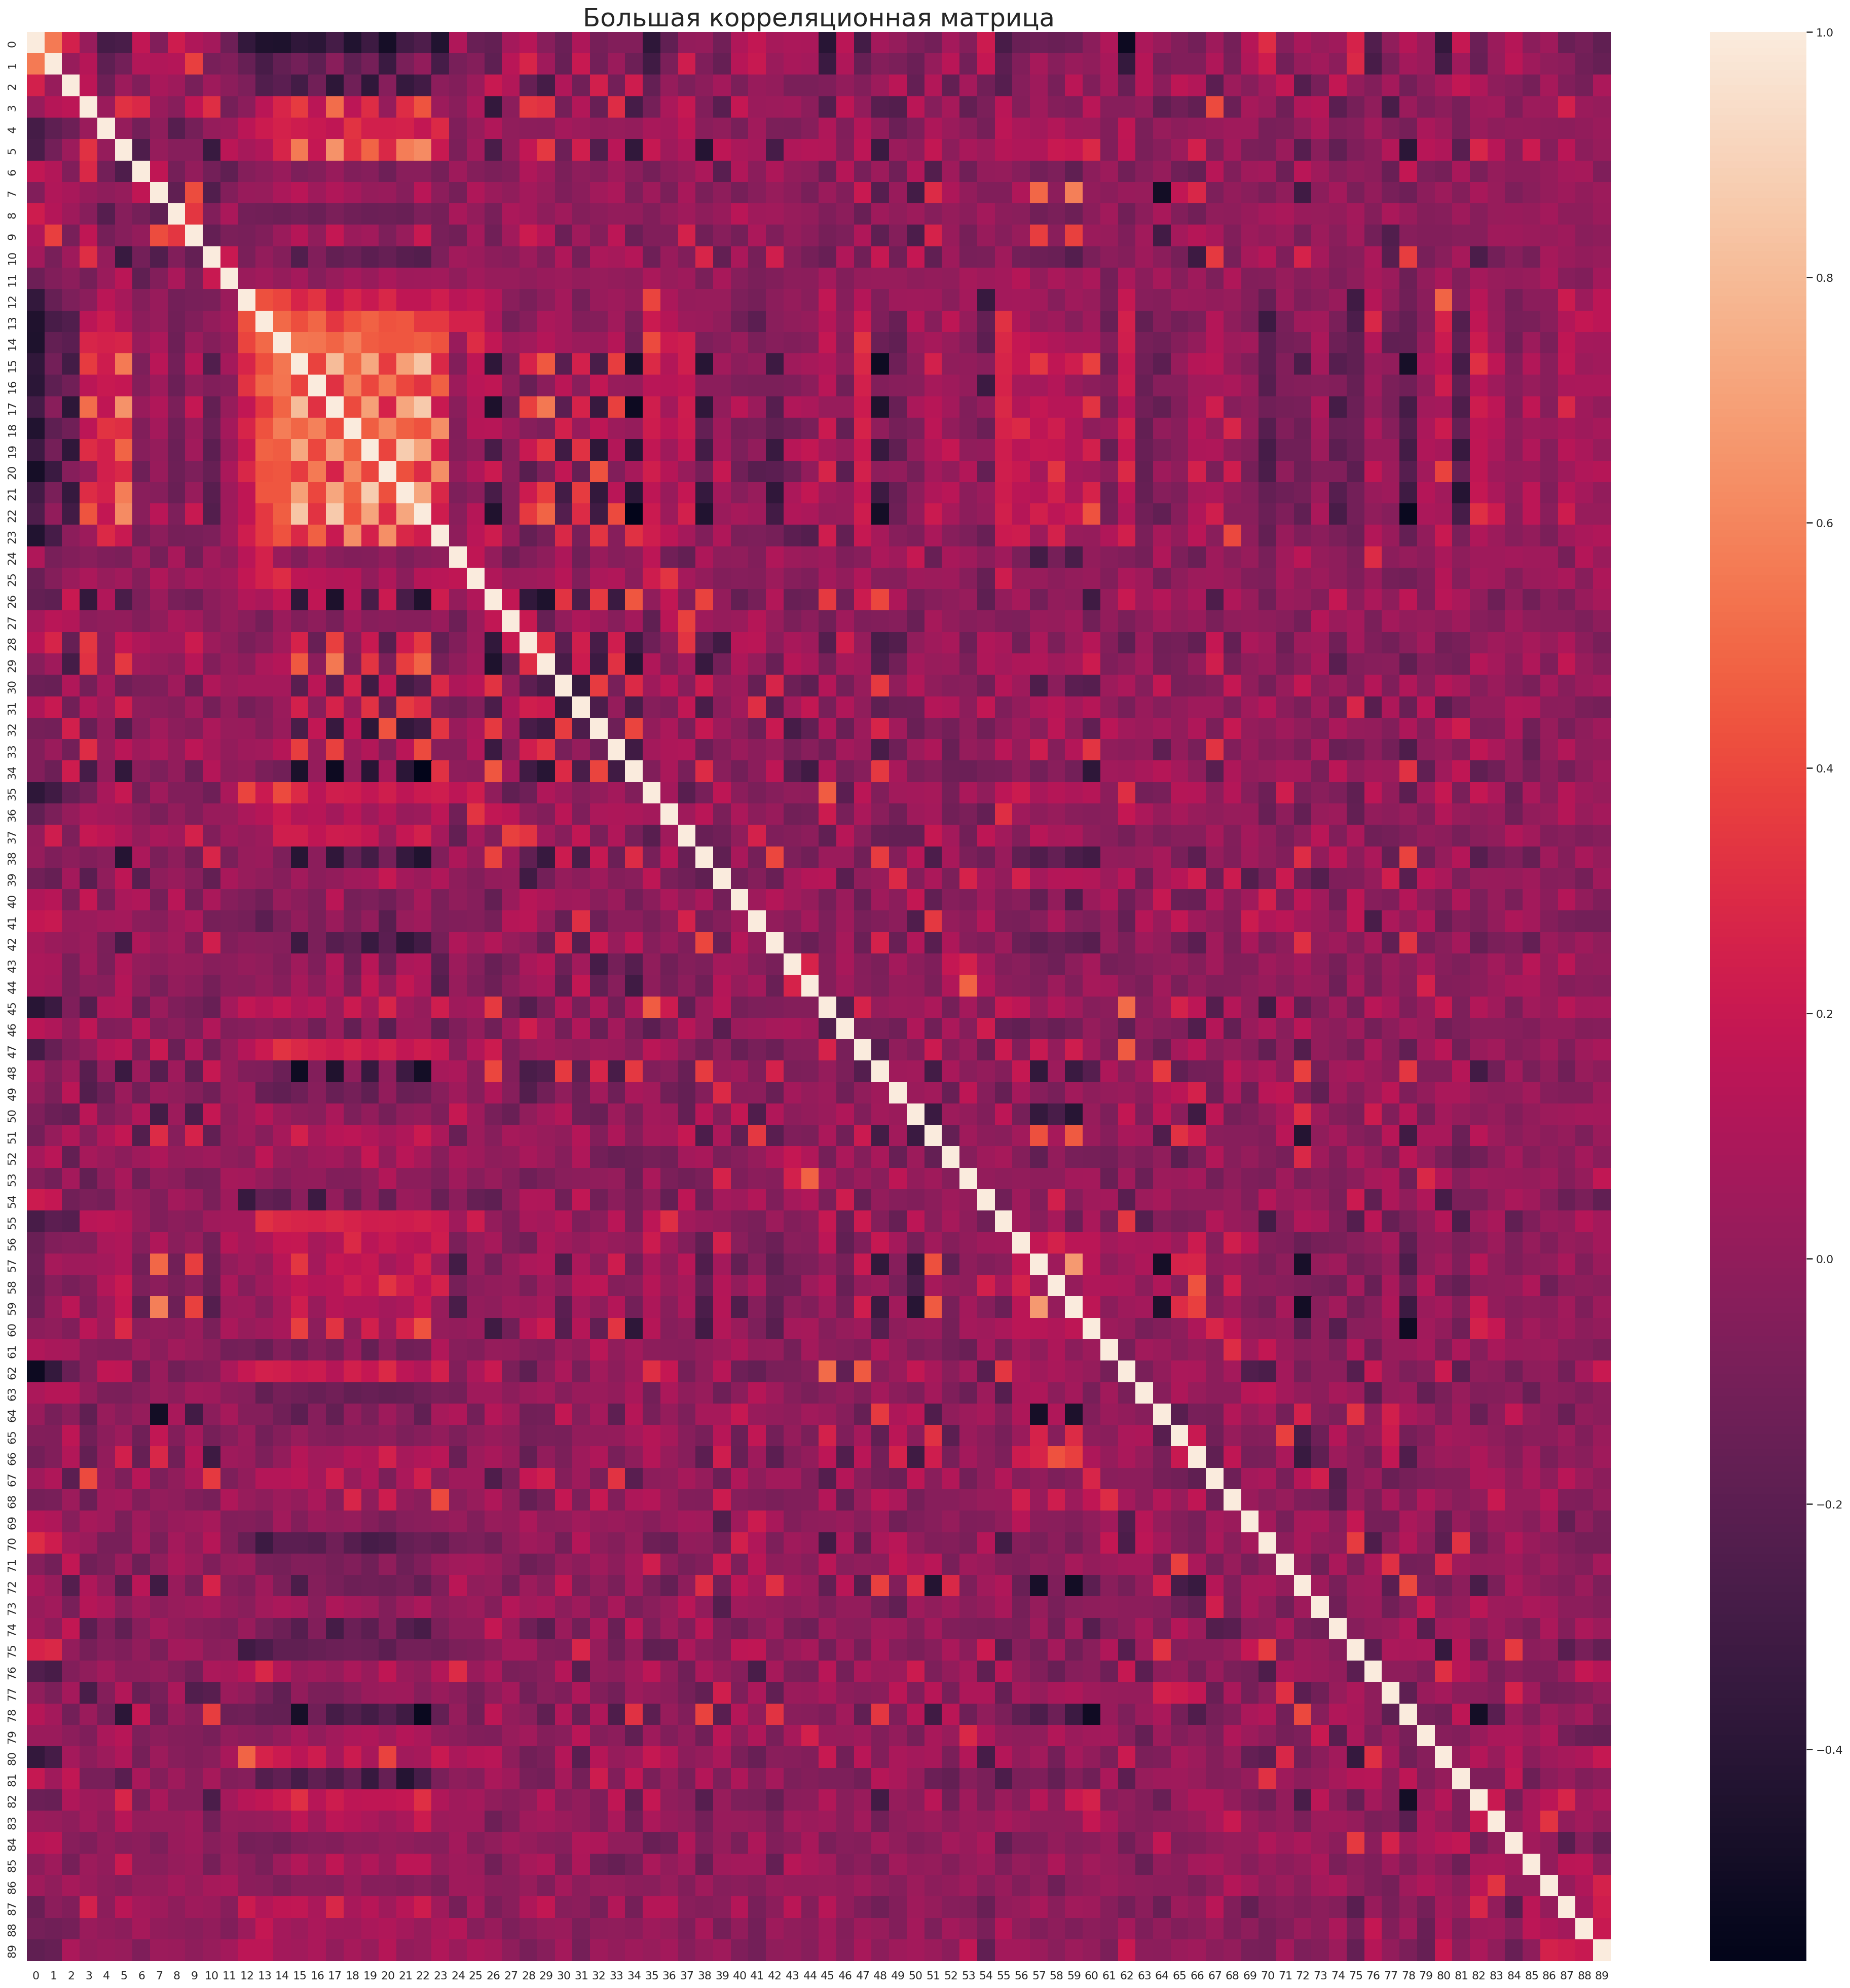

In [ ]:
fig, ax = plt.subplots(figsize=(35, 35))
ax = sns.heatmap(data=cor_data, ax=ax)
ax.set_title('Большая корреляционная матрица', fontsize=25);

Хотя матрица 90x90 (помним, что она симметричная), можно заметить несколько "корреляционных пятен", т.е. больших корреляций между 15-22 признаками, и несколько высоких отрицательных значений корреляции (выборочно). 

Теперь посмотрим на **распределение целевой переменой**.

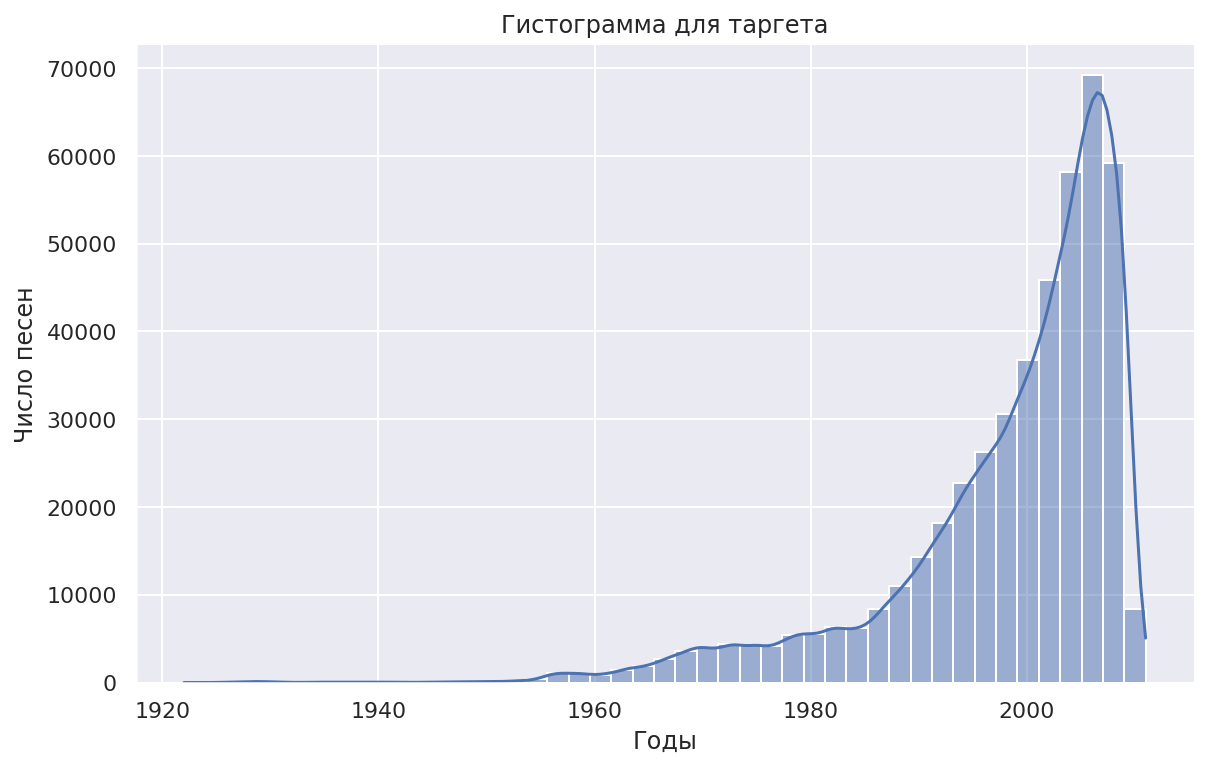

In [ ]:
hist = sns.displot(data=y_train,
            kde=True,
            bins=45,
            height=5,
            aspect=1.7).set(title='Гистограмма для таргета', xlabel='Годы', ylabel='Число песен');

Теперь посмотрим на тестовую выборку и сравним ее распределение *с нашими прогнозами из `Ridge`-регрессии:*

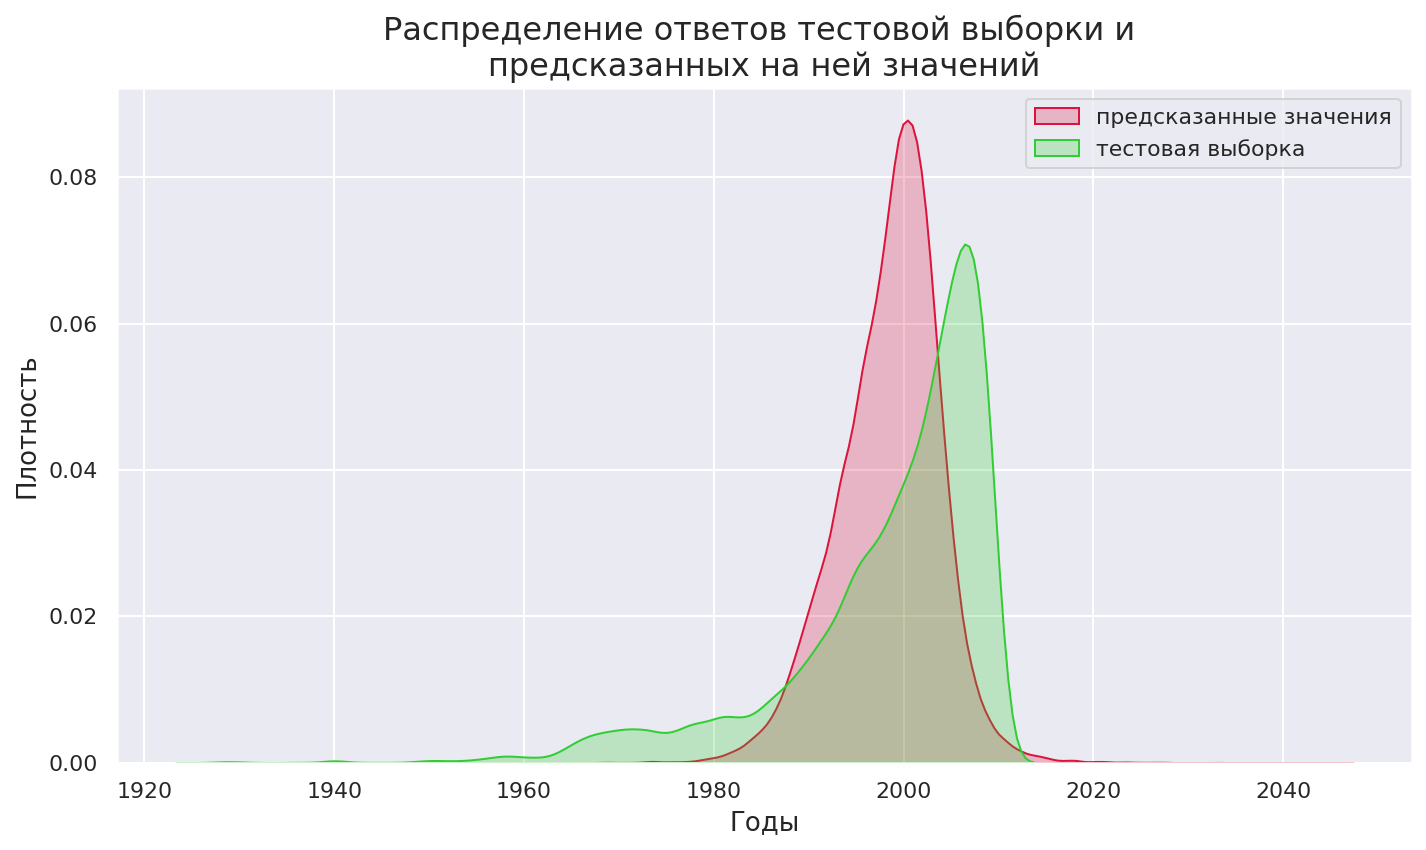

In [ ]:
# источник: https://translated.turbopages.org/proxy_u/en-ru.ru.3835a15e-63518d68-de66640a-74722d776562/https/stackoverflow.com/questions/71424546/combine-2-kde-functions-in-one-plot-in-seaborn

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(data=y_pred,
            color='crimson', label='предсказанные значения', fill=True, ax=ax)
sns.kdeplot(data=y_test,
            color='limegreen', label='тестовая выборка', fill=True, ax=ax)
plt.xlabel('Годы', fontsize=13)
plt.ylabel('Плотность', fontsize=13)
plt.title('Распределение ответов тестовой выборки и \nпредсказанных на ней значений', fontsize=16)
ax.legend()
plt.tight_layout()
plt.show()

Видим **плохую ситуацию**: 

* во-первых, распределение предсказанных значений нормальное, совершенно не соответствующее реальным данным (ответам);
* во-вторых, мы недополучаем значения с левой стороны и получаем несуществующие предсказания "из будущего", в то время как реальное распределение резко обрывается.

Посмотрим еще немного на целевую переменную.

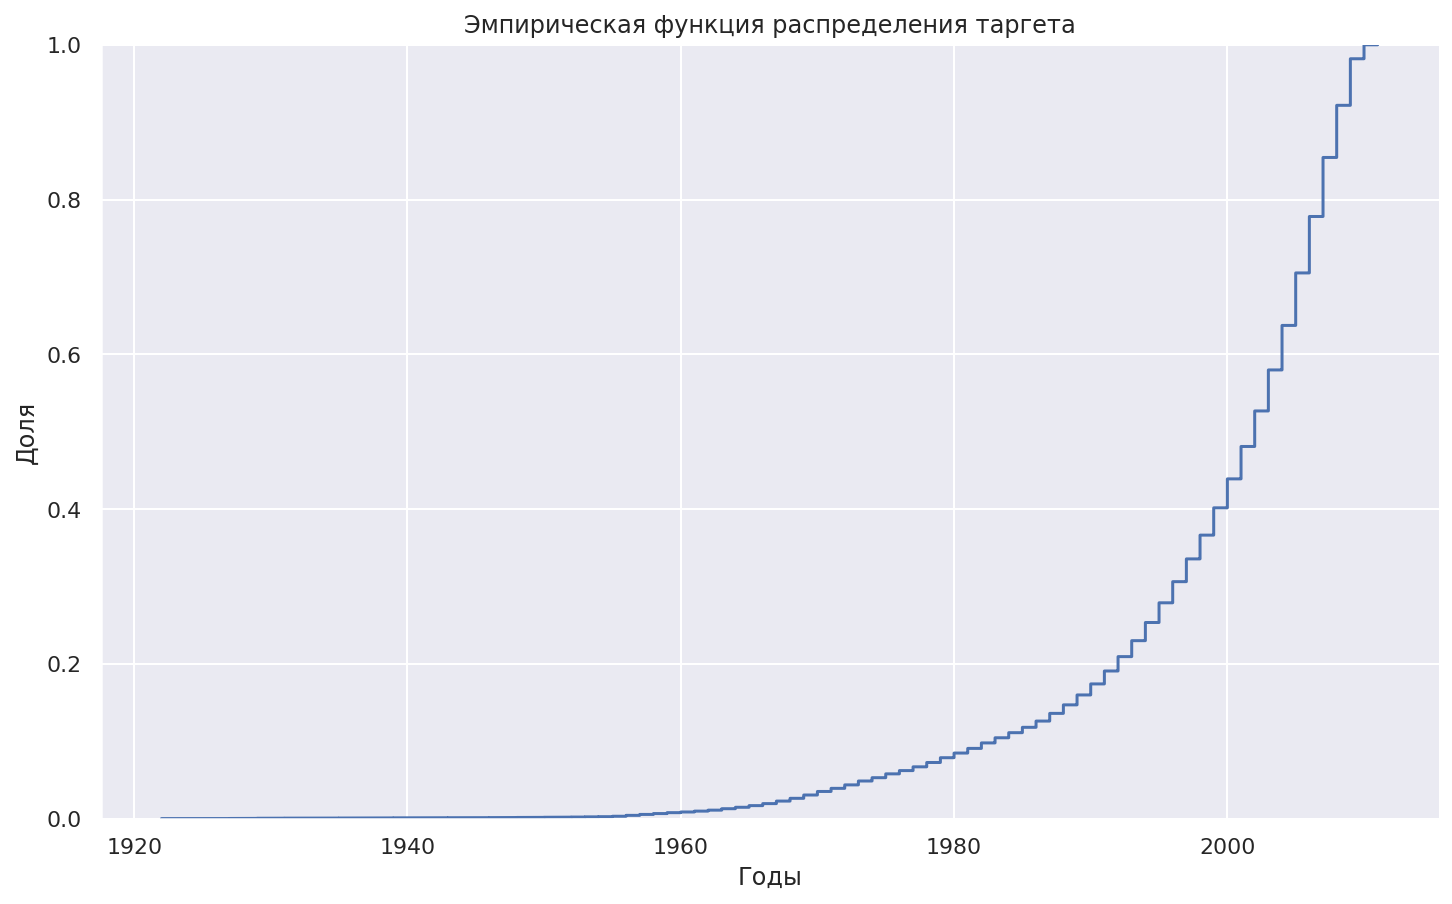

In [ ]:
sns.displot(data=y_train,
            kind='ecdf',
            height=6,
            aspect=1.7).set(title='Эмпирическая функция распределения таргета', xlabel='Годы', ylabel='Доля');

*Видим явный пик и скошенное вправо распределение обучающей выборки.*

Отличается ли что-то на *тестовой выборке*?

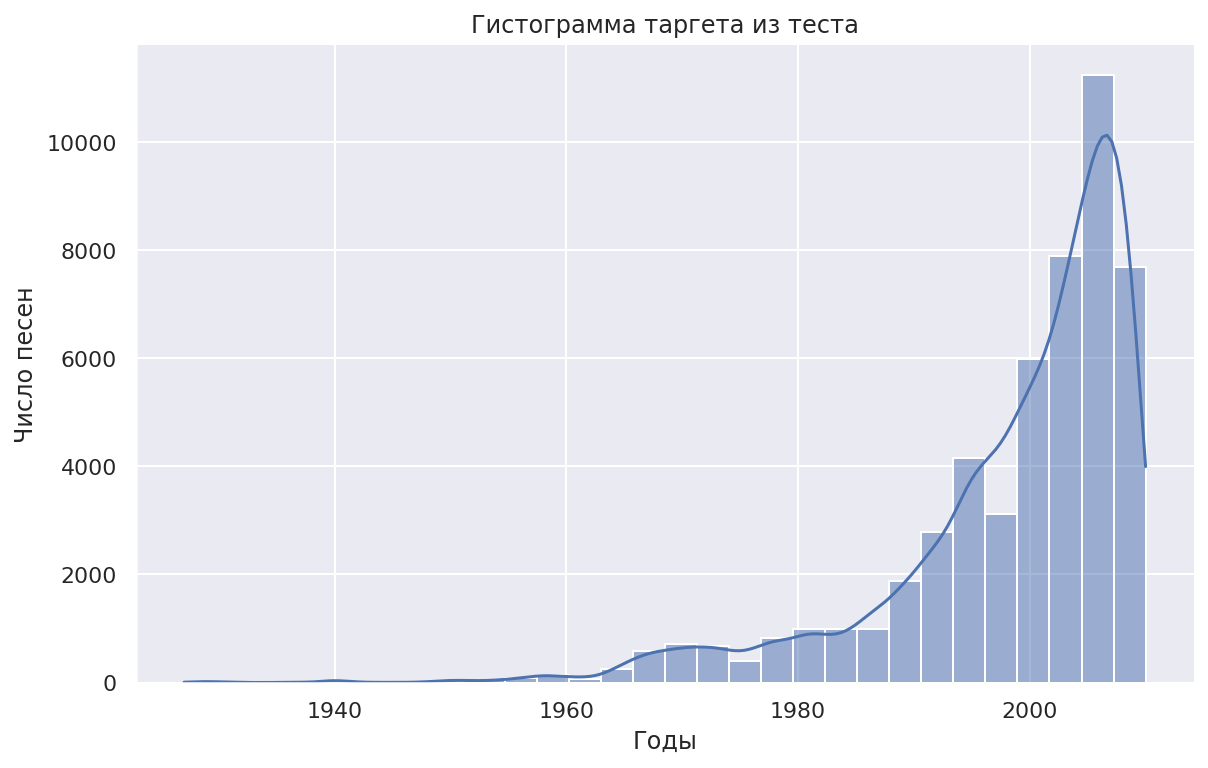

In [ ]:
hist = sns.displot(data=y_test,
            kde=True,
            bins=30,
            height=5,
            aspect=1.7).set(title='Гистограмма таргета из теста', xlabel='Годы', ylabel='Число песен');

На тестовой выборке без изменений, но слева значений немного больше ("холмик" между 1960 и 1980).

Посмотрим, на **распределение остатков**: где мы больше всего ошибаемся в обычной Ridge-регрессии. Для этого еще раз обучим ее и визуализируем разницу между предсказанными и наблюдаемыми значениями.

В начале на обучающей выборке:

In [ ]:
ridge = Ridge()
ridge.fit(X_train, y_train)
errors_train = np.sqrt((y_train - ridge.predict(X_train)) ** 2)

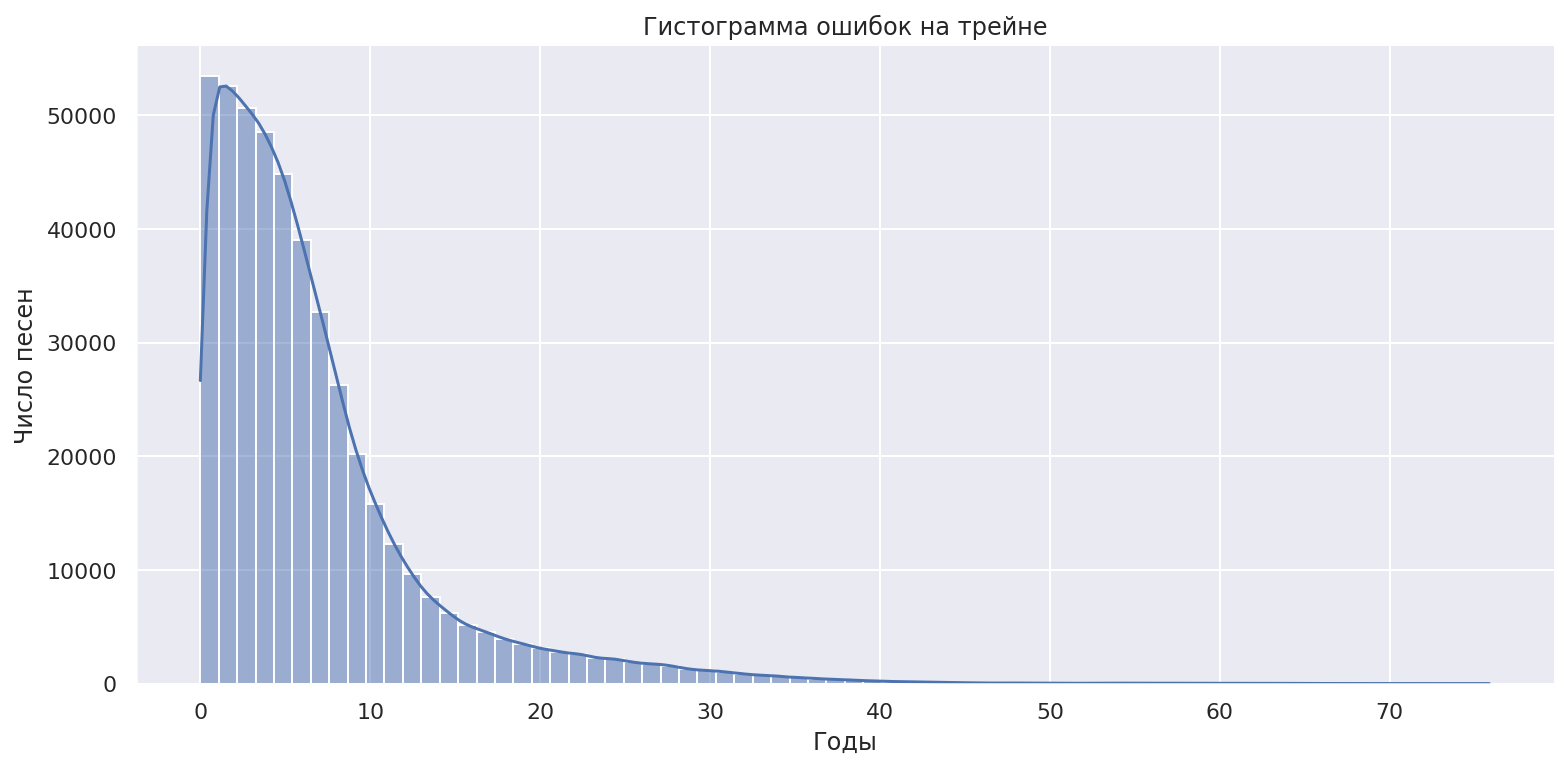

In [ ]:
hist = sns.displot(data=errors_train,
            kde=True,
            bins=70,
            height=5,
            aspect=2.2).set(title='Гистограмма ошибок на трейне', xlabel='Годы', ylabel='Число песен');

И на тесте:

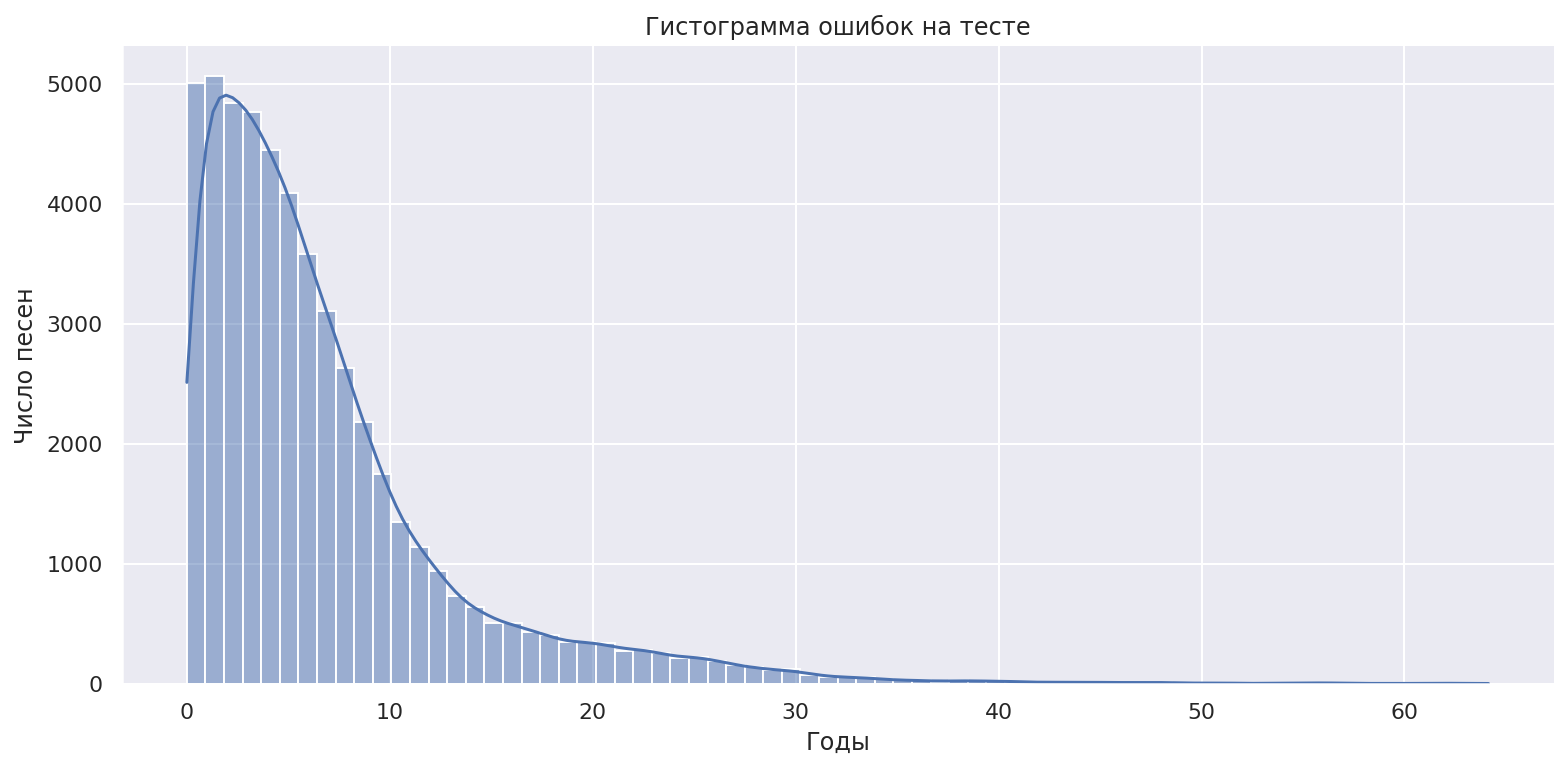

In [ ]:
errors_test = np.sqrt((y_test - ridge.predict(X_test)) ** 2)

hist = sns.displot(data=errors_test,
            kde=True,
            bins=70,
            height=5,
            aspect=2.2).set(title='Гистограмма ошибок на тесте', xlabel='Годы', ylabel='Число песен');

В целом, паттерн похожий и скошенный.

Попробуем избавиться от нетипичных наблюдений и переобучить модель:

In [ ]:
mask = (errors_train < np.quantile(errors_train, 0.95))
ridge.fit(X_train[mask], y_train[mask])
errors2 = np.sqrt((y_train[mask] - ridge.predict(X_train[mask])) ** 2)

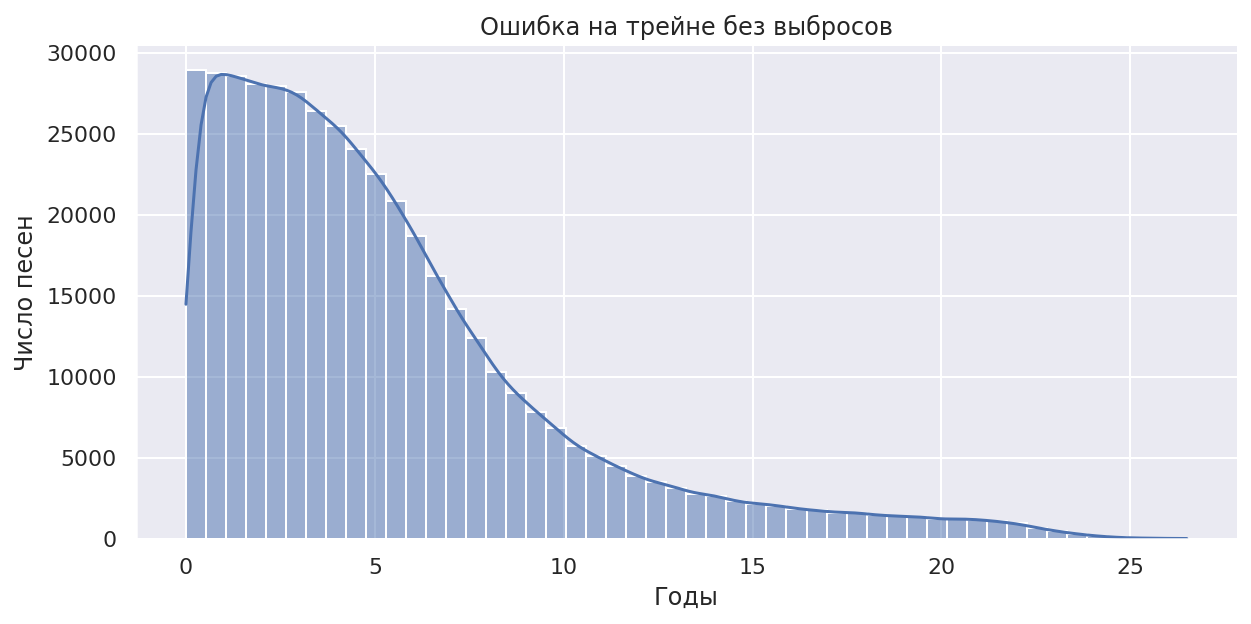

In [ ]:
hist = sns.displot(data=errors2,
            kde=True,
            bins=50,
            height=4,
            aspect=2.2).set(title='Ошибка на трейне без выбросов', xlabel='Годы', ylabel='Число песен');

Визуальнее стало гораздо лучше. Какой теперь лосс?

In [ ]:
mean_squared_error(y_train[mask], ridge.predict(X_train[mask]), squared=False)

6.94688456487735

Лосс тоже намного лучше. 

Значит, нас оттягивают очень большие (редкие) годы, попробуем побороть эту проблему.

## Нормирование целевой переменной

Мы убедились, что нам обязательно нужна нормировка. Сравним разные методы:

In [12]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler

In [ ]:
scaler = StandardScaler()
y_train_stand_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

In [ ]:
quant_scaler = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
y_train_quantile_scaled = quant_scaler.fit_transform(y_train.reshape(-1, 1))

In [ ]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_minmax_scaled = minmax_scaler.fit_transform(y_train.reshape(-1, 1))

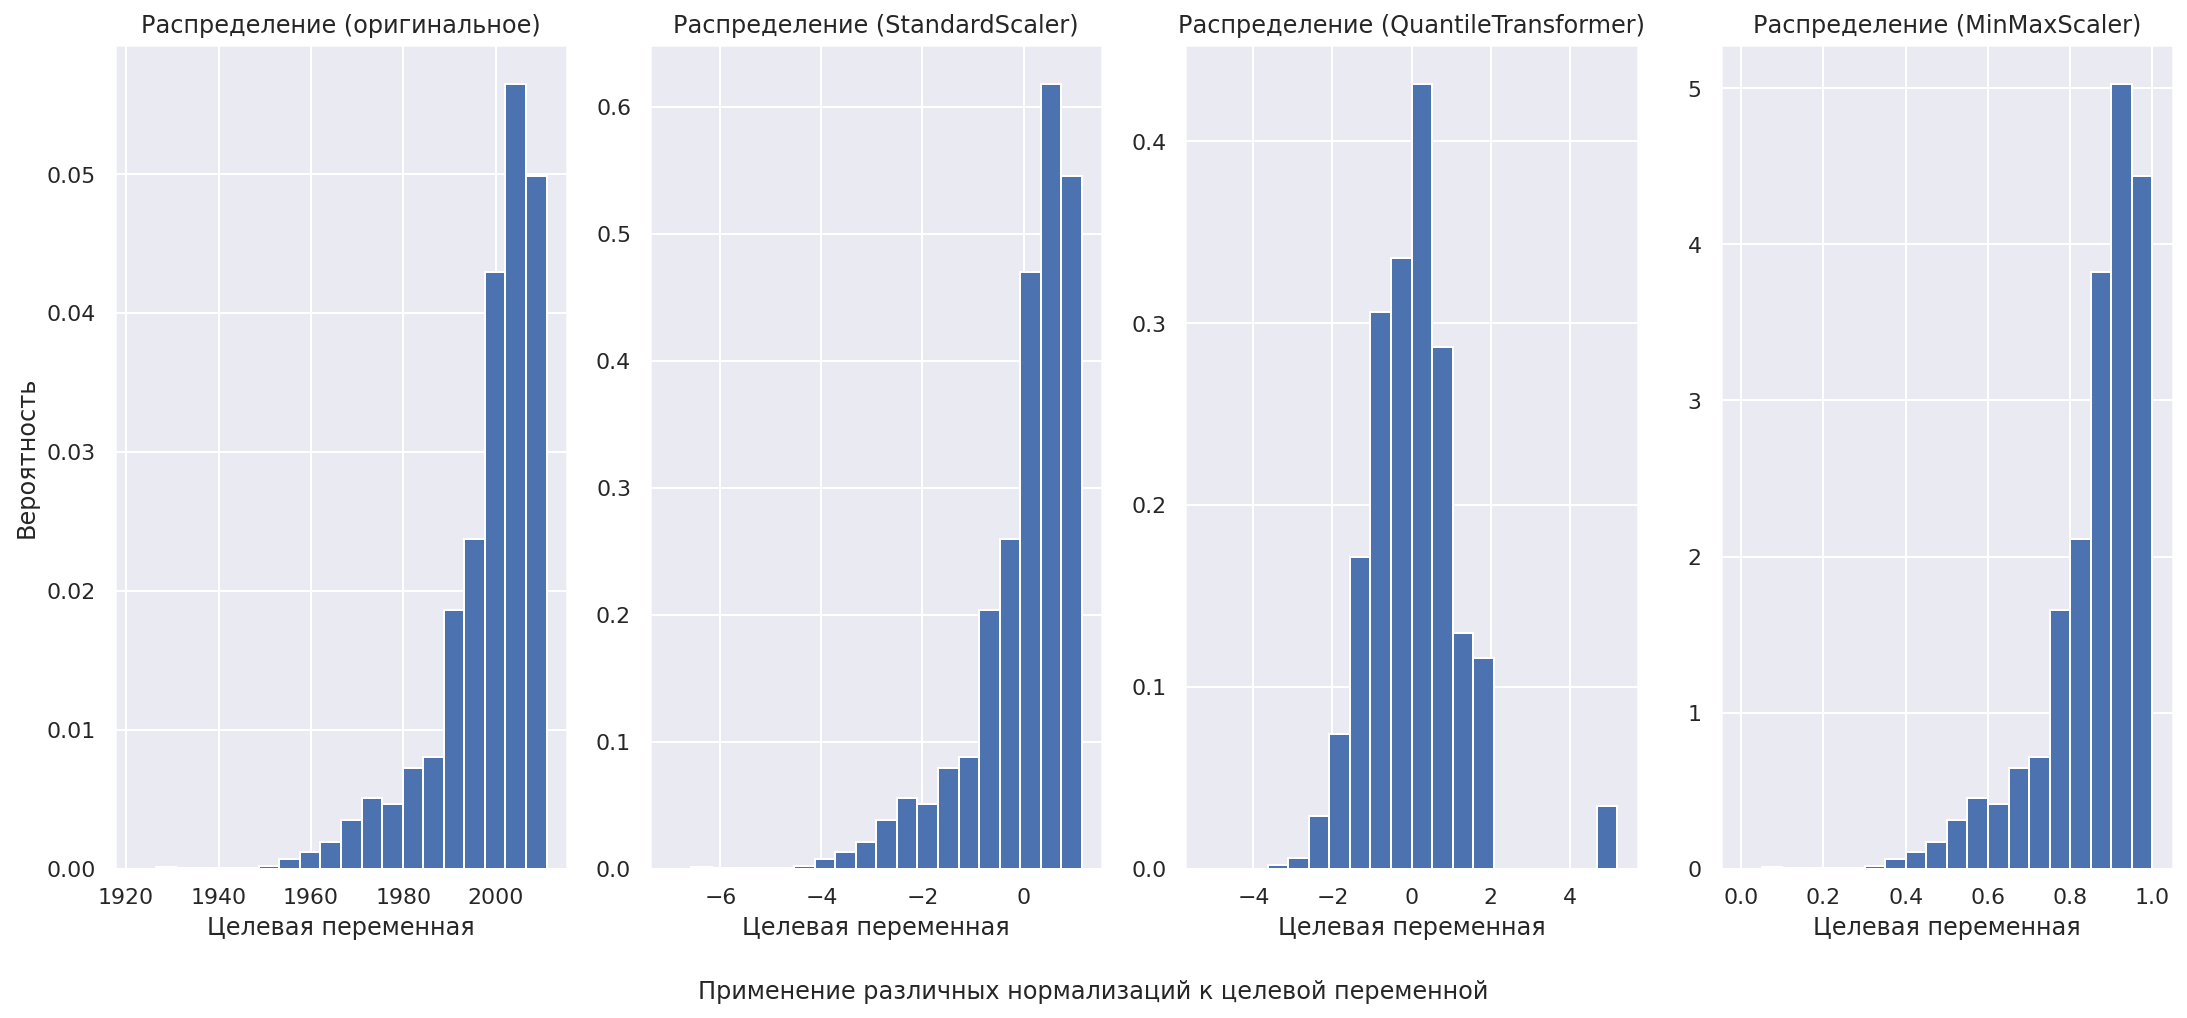

In [ ]:
f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(17,7.5))

ax0.hist(y_train, bins=20, density=True)
ax0.set_ylabel('Вероятность')
ax0.set_xlabel('Целевая переменная')
ax0.set_title('Распределение (оригинальное)')

ax1.hist(y_train_stand_scaled, bins=20, density=True)
ax1.set_ylabel('')
ax1.set_xlabel('Целевая переменная')
ax1.set_title('Распределение (StandardScaler)')

ax2.hist(y_train_quantile_scaled, bins=20, density=True)
ax2.set_ylabel('')
ax2.set_xlabel('Целевая переменная')
ax2.set_title('Распределение (QuantileTransformer)')

ax3.hist(y_train_minmax_scaled, bins=20, density=True)
ax3.set_ylabel('')
ax3.set_xlabel('Целевая переменная')
ax3.set_title('Распределение (MinMaxScaler)')

f.suptitle("Применение различных нормализаций к целевой переменной", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

Визуально и содержательно (статистически) мне больше всего понравились `QuantileTransformer` и `StandardScaler`. **Сравним их** поближе:

In [ ]:
y_train_quant = quant_scaler.fit_transform(y_train.reshape(-1, 1)).squeeze()

y_test_quant = quant_scaler.transform(y_test.reshape(-1, 1)).squeeze()

In [ ]:
y_train_standscaled = scaler.fit_transform(y_train.reshape(-1, 1)).squeeze()

y_test_standscaled = scaler.transform(y_test.reshape(-1, 1)).squeeze()

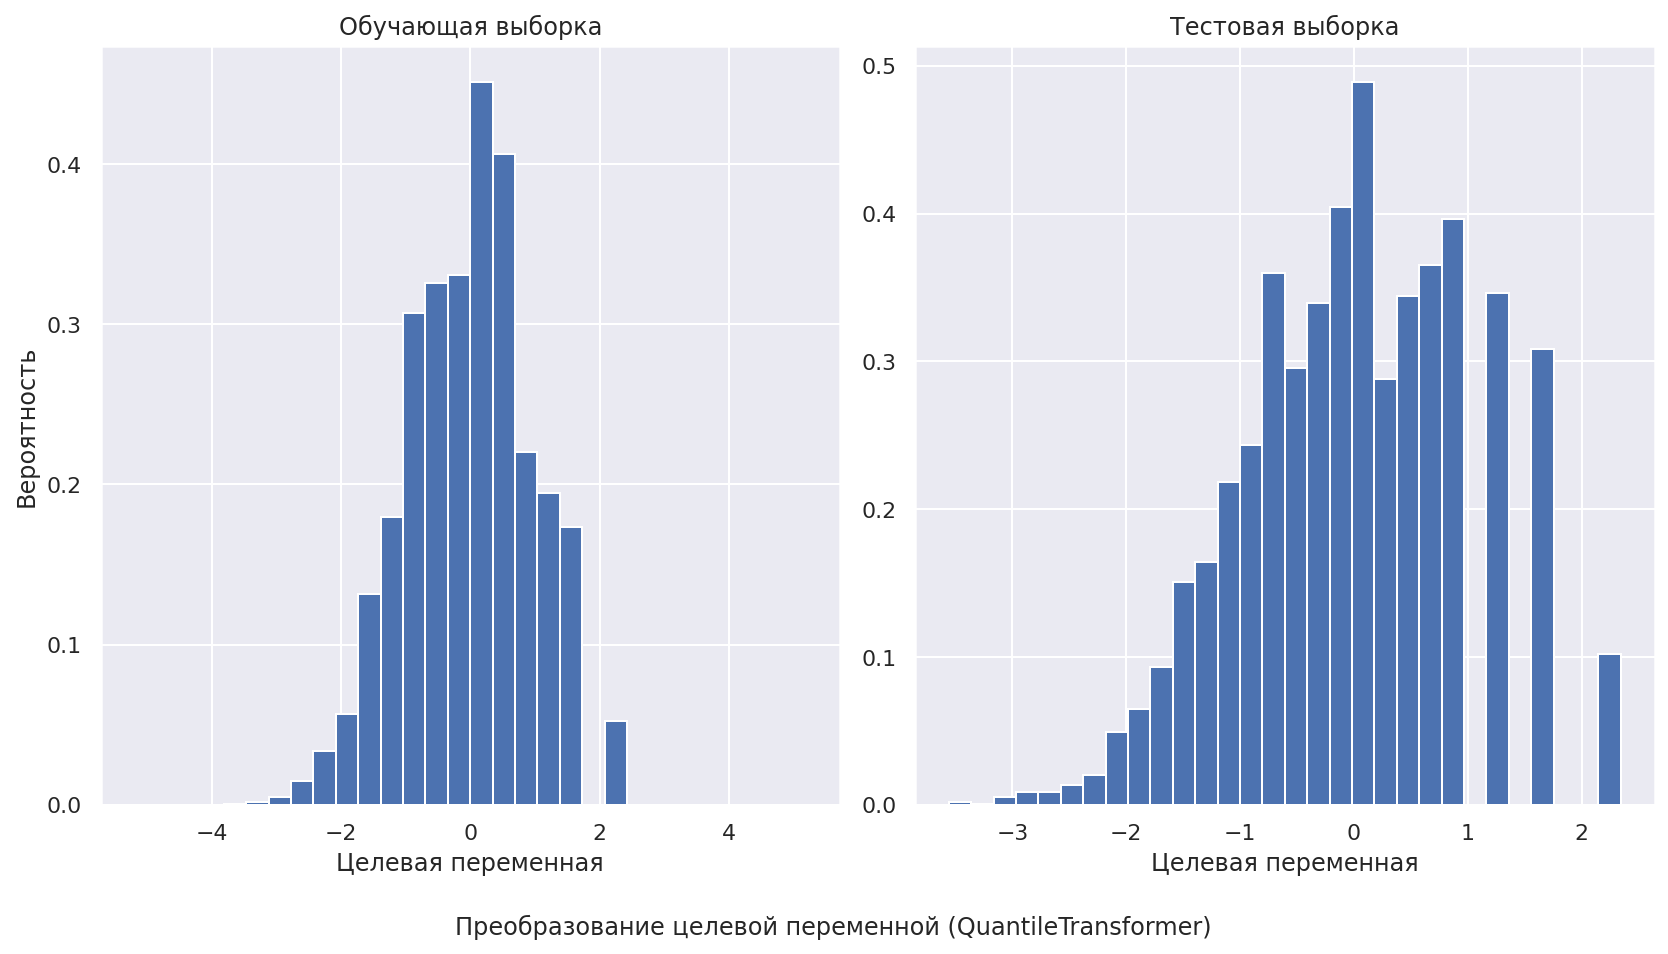

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(13,7))

ax0.hist(y_train_quant, bins=30, density=True)
ax0.set_ylabel('Вероятность')
ax0.set_xlabel('Целевая переменная')
ax0.set_title('Обучающая выборка')

ax1.hist(y_test_quant, bins=30, density=True)
ax1.set_ylabel('')
ax1.set_xlabel('Целевая переменная')
ax1.set_title('Тестовая выборка')

f.suptitle("Преобразование целевой переменной (QuantileTransformer)", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

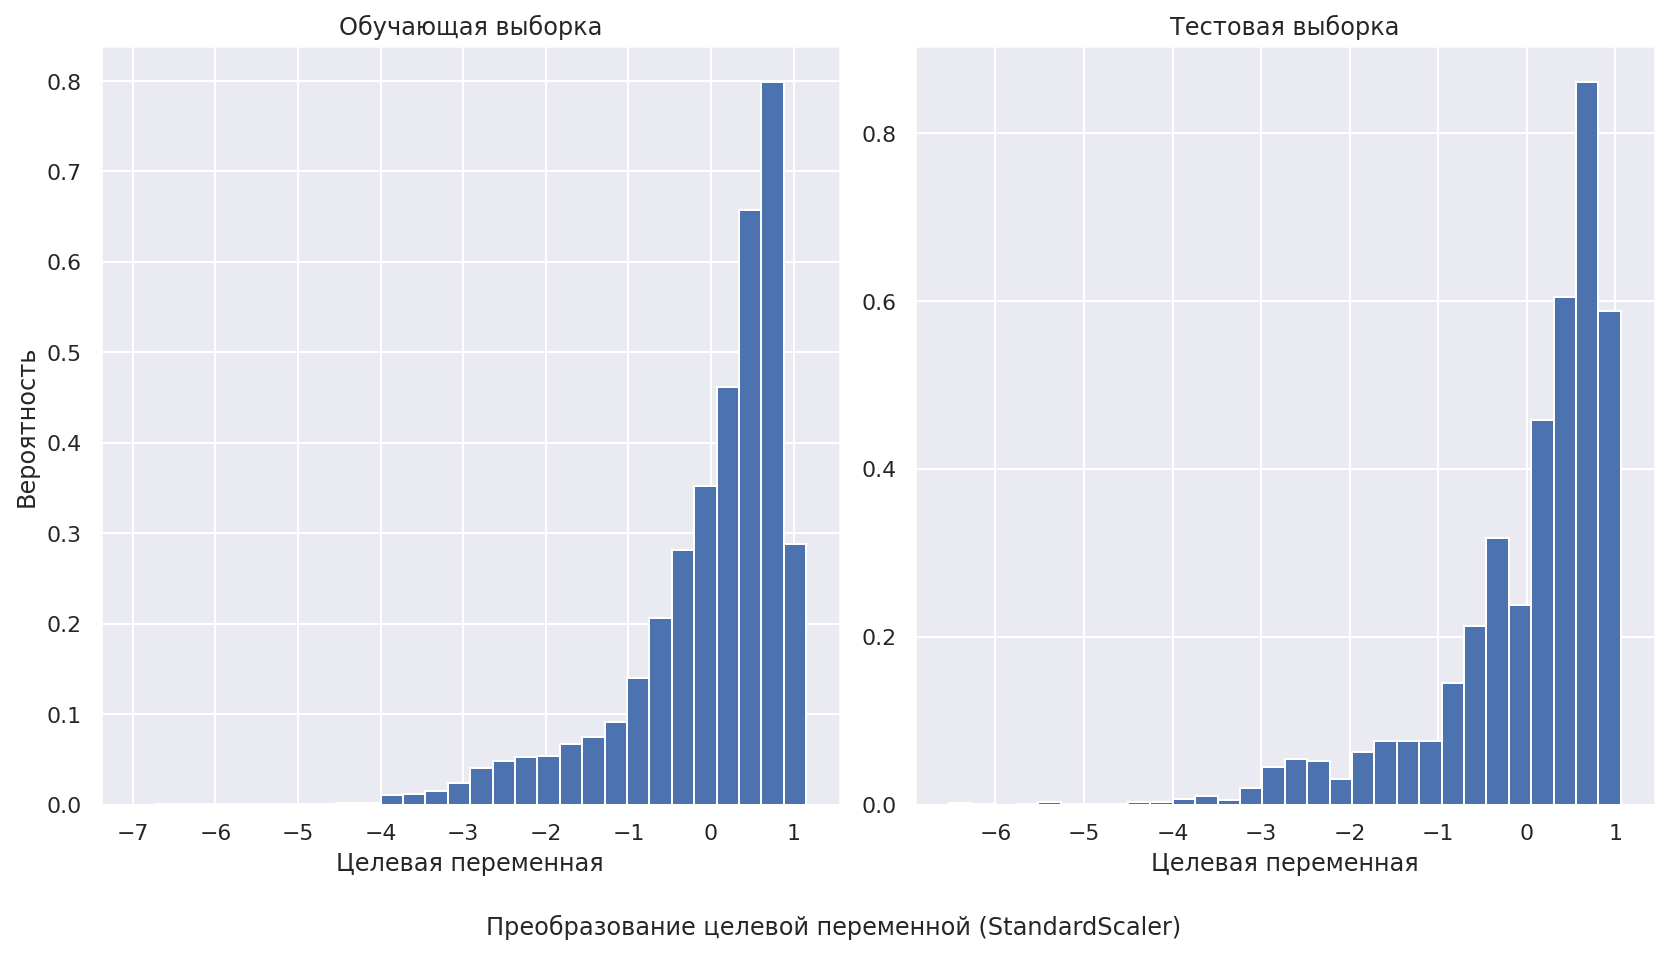

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(13,7))

ax0.hist(y_train_standscaled, bins=30, density=True)
ax0.set_ylabel('Вероятность')
ax0.set_xlabel('Целевая переменная')
ax0.set_title('Обучающая выборка')

ax1.hist(y_test_standscaled, bins=30, density=True)
ax1.set_ylabel('')
ax1.set_xlabel('Целевая переменная')
ax1.set_title('Тестовая выборка')

f.suptitle("Преобразование целевой переменной (StandardScaler)", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

*Выбор будет сделан в пользу второго варианта (`StandardScaler`)*, поскольку квантильное (нелинейное) преобразование может дать "сбои" при переводе обратно, т.к. (это было видно на гистограмме), т.к. в нем есть "пробелы" из-за того, что мы преобразуем тестовую выборку по параметрам обучающей выборки, и в случае нелинейного преобразования это не выглядит оптимально.

Понятно, что у `StandardScaler` *такой проблемы не будет*, т.к. он не меняет само распределение, только значения, которые принимает целевая переменная.

---

Далее также **нормируем признаки** с помощью `StandardScaler`:

In [13]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))  # нормируем ответы в конце, чтобы потом преобразовать обратно с этими же параметрами

## Модель

Настало время начать работу над **архитектурой** модели.

Создадим классы для загрузки данных и запишем основную информацию про модель. Гиперпараметры будут подобраны ниже и вставлены в эту архитектуру.

In [14]:
class MyDataset(torch.utils.data.Dataset):
    """
    My scaled dataset
    """
    def __init__(self, x, y, transform = None):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return [torch.tensor(self.x[idx, :], dtype=torch.float), torch.tensor(self.y[idx], dtype=torch.float)]

In [55]:
train_set = MyDataset(X_train_scaled, y_train_scaled)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True)

test_set = MyDataset(X_test_scaled, y_test_scaled)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, pin_memory=True)

model = nn.Sequential(
    nn.Linear(90, 220),
    nn.BatchNorm1d(220),
    nn.LeakyReLU(),
    nn.Dropout(0.2),

    nn.Linear(220, 180),
    nn.BatchNorm1d(180),
    nn.LeakyReLU(),
    nn.Dropout(0.25),

    nn.Linear(180, 90),
    nn.BatchNorm1d(90),
    nn.LeakyReLU(),
    nn.Dropout(0.3),

    nn.Linear(90, 60),
    nn.BatchNorm1d(60),
    nn.LeakyReLU(),
    nn.Dropout(0.3),

    nn.Linear(60, 30),
    nn.BatchNorm1d(30),
    nn.Dropout(0.3),
    nn.LeakyReLU(),

    nn.Linear(30, 1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=1.13646367e-03)  # другие хорошие lr = 1.66810054e-02 / 6.81292069e-03 / 7.74263683e-03
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33411111111111114, last_epoch=-1, verbose=True)  # каждые 3 эпохи уменьшаем lr и печатаем его
criterion = nn.MSELoss()

Adjusting learning rate of group 0 to 1.1365e-03.


Залогинимся в `wandb`, чтобы отслеживать много интересных параметров.

In [ ]:
!pip install wandb

In [17]:
import wandb

# логинимся
wandb.login() # уже авторизованы, id не вводим
# инициализируем проект
wandb.init(project="hw-1")
# сохраняем параметры сетки в wandb + просим следить за градиентами сетки
wandb.watch(model);

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rubanoww. Use `wandb login --relogin` to force relogin


Позаимствуем из семинара №3 функцию для отрисовки графика:

In [18]:
def plot_history(train_history, val_history, title="Функция потерь"): # sem 3
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train", zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c="orange", label="val loss", zorder=2)
    plt.xlabel("Шаги обучения (батчи)")
    
    plt.legend(loc="best")
    plt.grid()

    plt.show()

Напишем две функции для прохождения одной тренировочной и валидационной эпох:

In [19]:
def go_one_epoch_train(model, optimizer, criterion, train_loader, device, train_loss_history):
    '''
    Функция реализует обучение по одной эпохе.
    ----------
    параметры:
        model - наследованная torch.nn.Module архитектура нейросети
        optimizer - оптимизатор модели
        criterion - функция потерь из torch.nn
        train_loader - наследованный от torch.utils.data.Dataloader класс с обучающей выборкой
        device - используемый ускоритель ('cuda' / 'cpu')
        train_loss_history - массив для логов, созданный ранее
    ----------
    Возвращает значение функции потерь (RMSE) по эпохе,
        которое рассчитывается по следующей формуле:
        $\sqrt{\dfrac{\sum MSE(on\_batch) \cdot batch\_size}{l}}$
    '''
    batch_loss = torch.empty(0)             # создаем тензор для лосса
    model.train().to(device)                # отправляем модель на обучение и на ускоритель 

    for x, y in tqdm(train_loader):         # достаем данные из обуч. выборки
        x, y = x.to(device), y.to(device)   # помещаем их на ускоритель
        
        y_pred = model(x)                   # предсказываем
        loss = criterion(y_pred, y)         # считаем лосс
        loss.backward()                     # считаем градиенты через обратное распр-е
        optimizer.step()                    # делаем градиентный шаг
        optimizer.zero_grad()               # обнуляем градиенты параметров
        
        # перемещаем лосс на процессор, умножаем его на число объектов в батче и кладем его в тензор
        batch_loss = torch.cat((batch_loss, loss.cpu().unsqueeze(0).data * y.cpu().size(0)))
        train_loss_history.append(torch.sqrt(loss.cpu().data)) # записываем лосс по батчу в историю
    
    # считаем корректный RMSE по эпохе: суммируем и делим на число объектов в обуч. выборке, 
    # потом берем квадратный корень
    epoch_loss = torch.sqrt(torch.sum(batch_loss) / len(train_loader.dataset))

    return epoch_loss


def go_one_epoch_val(model, optimizer, criterion, test_loader, device):
    '''
    Функция реализует валидацию по одной эпохе.
    ----------
    параметры:
        model - наследованная torch.nn.Module архитектура нейросети
        optimizer - оптимизатор модели
        criterion - функция потерь из torch.nn
        test_loader - наследованный от torch.utils.data.Dataloader класс с тестовой выборкой
        device - используемый ускоритель ('cuda' / 'cpu')
    ----------
    Возвращает значение функции потерь (RMSE) по эпохе,
        которое рассчитывается по следующей формуле:
        $\sqrt{\dfrac{\sum MSE(on\_batch) \cdot batch\_size}{l}}$
    и не считает градиенты
    '''

    val_loss_epoch = torch.empty(0)                # создаем тензор для лосса
    model.eval().to(device)                        # отправляем модель на валидацию и на ускоритель

    with torch.no_grad():                          # не считаем градиенты
        for x, y in tqdm(test_loader):             # достаем данные из тестовой выборки
            x, y = x.to(device), y.to(device)      # помещаем их на ускоритель
            y_pred = model(x)                      # предсказываем
            loss = criterion(y_pred, y)            # считаем лосс

            # перемещаем лосс на процессор, умножаем его на число объектов в батче и кладем его в тензор
            val_loss_epoch = torch.cat((val_loss_epoch, loss.cpu().unsqueeze(0).data * y.cpu().size(0)))

    # считаем корректный RMSE по эпохе: суммируем и делим на число объектов в тестовой. выборке, 
    # потом берем квадратный корень       
    epoch_loss = torch.sqrt(torch.sum(val_loss_epoch) / len(test_loader.dataset))

    return epoch_loss
    

Напишем функцию для тренировки и теста:

In [20]:
def train(model, optimizer, criterion, train_loader, test_loader, device, scheduler, n_epochs):
    '''
    Функция проводит обучение по числу заданных эпох.
    Для использования требует определение трех дополнительных функций:
        go_one_epoch_train   проводит обучение по одной эпохе
        go_one_epoch_val     проводит валидацию по одной эпохе
        plot_history         отрисовывает графики
    ----------
    параметры:
        model - наследованная torch.nn.Module архитектура нейросети для обучения
        optimizer - оптимизатор модели
        criterion - функция потерь из torch.nn
        train_loader - наследованный от torch.utils.data.Dataloader класс с обучающей выборкой
        test_loader - наследованный от torch.utils.data.Dataloader класс с тестовой выборкой 
            (для валидации)
        device - используемый ускоритель ('cuda' / 'cpu')
        scheduler - наследованный от torch.optim.lr_scheduler класс для изменения lr в ходе обучения
        n_epochs - число эпох для обучения
    '''
    
    train_loss_history = []  # массив для сохранения истории обучения
    val_loss_history = []    # массив для сохранения истории валидации
    
    for epoch in range(n_epochs):
        # обучение
        # проводим обучающую эпоху, определенную ранее
        # и записываем лосс по эпохе на обучении
        train_loss_mean_one_epoch = go_one_epoch_train(model, optimizer, 
                                                    criterion, train_loader, 
                                                    device, train_loss_history) 

        # валидация на тесте
        # проводим валидационную эпоху, определенную ранее
        # и записываем лосс по эпохе на валидации
        val_loss_mean_one_epoch = go_one_epoch_val(model, optimizer, criterion, test_loader, device)
        val_loss_history.append(val_loss_mean_one_epoch)
        
        # отправляем метрики на wandb и смотрим на графики на сайте
        wandb.log({"mean train loss (rmse)": train_loss_mean_one_epoch,
                   "mean val loss (rmse)": val_loss_mean_one_epoch})

        # печатаем график и метрики
        # очищаем выдачу
        clear_output()

        print(f"Epoch: {epoch + 1}, \nloss_train: {train_loss_mean_one_epoch}, \nloss_test: {val_loss_mean_one_epoch}")
        plot_history(train_loss_history, val_loss_history, 'Процесс обучения и валидации')

        # обновляем lr
        scheduler.step()

def test(model, test_loader):
    '''
    Функция применяет обученную модель к тестовой выборке.
    Метрики качества считаются отдельно.
    ----------
    параметры:
        model - обученная модель, наследованная из класса torch.nn.Module
        test_loader - наследованный от torch.utils.data.Dataloader класс с тестовой выборкой 
            (для предсказания)
    ----------
    Возвращает:
        predicts - torch.tensor размера (len(test_loader.dataset), ),
                   содержит предсказания модели на тестовой выборке.
    '''
    predicts = torch.empty(0)                   # создаем тензор для предсказаний

    model.eval().to(device)                     # отправляем модель на валидацию и на ускоритель
    with torch.no_grad():                       # не считаем градиенты
        for x, y in tqdm(test_loader):          # достаем данные из тестовой выборки
            x, y = x.to(device), y.to(device)   # помещаем их на ускоритель
            y_pred = model(x)                   # предсказываем

            # вытягиваем полученные по батчу предсказанные значения в вектор,
            # перемещаем на ускоритель и кладем в тензор 
            predicts = torch.cat((predicts, torch.reshape(y_pred, (-1,)).cpu().data))
            
    return torch.reshape(predicts, (-1,))

Попробуем *подобрать оптимальный LR* вручную.

Будем на каждой итерации цикла обновлять модель, чтобы избежать эффекта "дообучения" и чтобы результаты были корректными.

In [ ]:
print(f'Первая проверка: {np.logspace(-6, 1, 10)}, \n\nВторая проверка: {np.logspace(-4.5, -1, 10)}')  # в начале проверил по первому массиву, затем сузил до второго

Первая проверка: [1.00000000e-06 5.99484250e-06 3.59381366e-05 2.15443469e-04
 1.29154967e-03 7.74263683e-03 4.64158883e-02 2.78255940e-01
 1.66810054e+00 1.00000000e+01], 

Вторая проверка: [3.16227766e-05 7.74263683e-05 1.89573565e-04 4.64158883e-04
 1.13646367e-03 2.78255940e-03 6.81292069e-03 1.66810054e-02
 4.08423865e-02 1.00000000e-01]


Epoch: 10, 
loss_train: 0.798200786113739, 
loss_test: 0.800758421421051


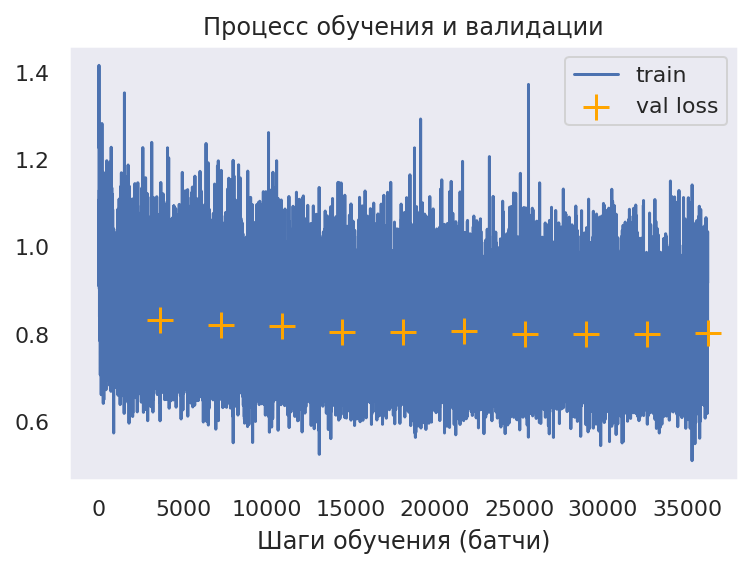

Adjusting learning rate of group 0 to 3.7297e-03.


  0%|          | 0/404 [00:00<?, ?it/s]

In [ ]:
set_random_seed(13)              # фиксируем сид
lr_s = np.logspace(-4.5, -1, 10) # в начале был перебор np.logspace(-6, 1, 10)
lr_results = []                  # создаем массив для лосса

for lr_i in lr_s: # итерируемся по разным значениям lr
    # переопределяем модель для новой инициализации и корректного сравнения
    train_set = MyDataset(X_train_scaled, y_train_scaled)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True)

    test_set = MyDataset(X_test_scaled, y_test_scaled)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, pin_memory=True)

    model = nn.Sequential(
        nn.Linear(90, 220),
        nn.BatchNorm1d(220),
        nn.LeakyReLU(),
        nn.Dropout(0.2),

        nn.Linear(220, 180),
        nn.BatchNorm1d(180),
        nn.LeakyReLU(),
        nn.Dropout(0.25),

        nn.Linear(180, 90),
        nn.BatchNorm1d(90),
        nn.LeakyReLU(),
        nn.Dropout(0.3),

        nn.Linear(90, 60),
        nn.BatchNorm1d(60),
        nn.LeakyReLU(),
        nn.Dropout(0.3),

        nn.Linear(60, 30),
        nn.BatchNorm1d(30),
        nn.Dropout(0.3),
        nn.LeakyReLU(),

        nn.Linear(30, 1)
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr_i) # меняем lr
    # до подбора оптимального значения gamma, этот гиперпараметр был равен 1 (т.е. шаг не менялся)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33411111111111114, last_epoch=-1, verbose=True) # обновляем lr каждые 3 эпохи
    criterion = nn.MSELoss()
    
    train(model, optimizer, criterion, train_loader, test_loader, device, scheduler, n_epochs=10) # обучаемся на 10 эпохах
    predicts = test(model, criterion, test_loader)

    lr_results.append(mean_squared_error(scaler.inverse_transform(predicts.reshape(-1, 1)), y_test, squared=False))

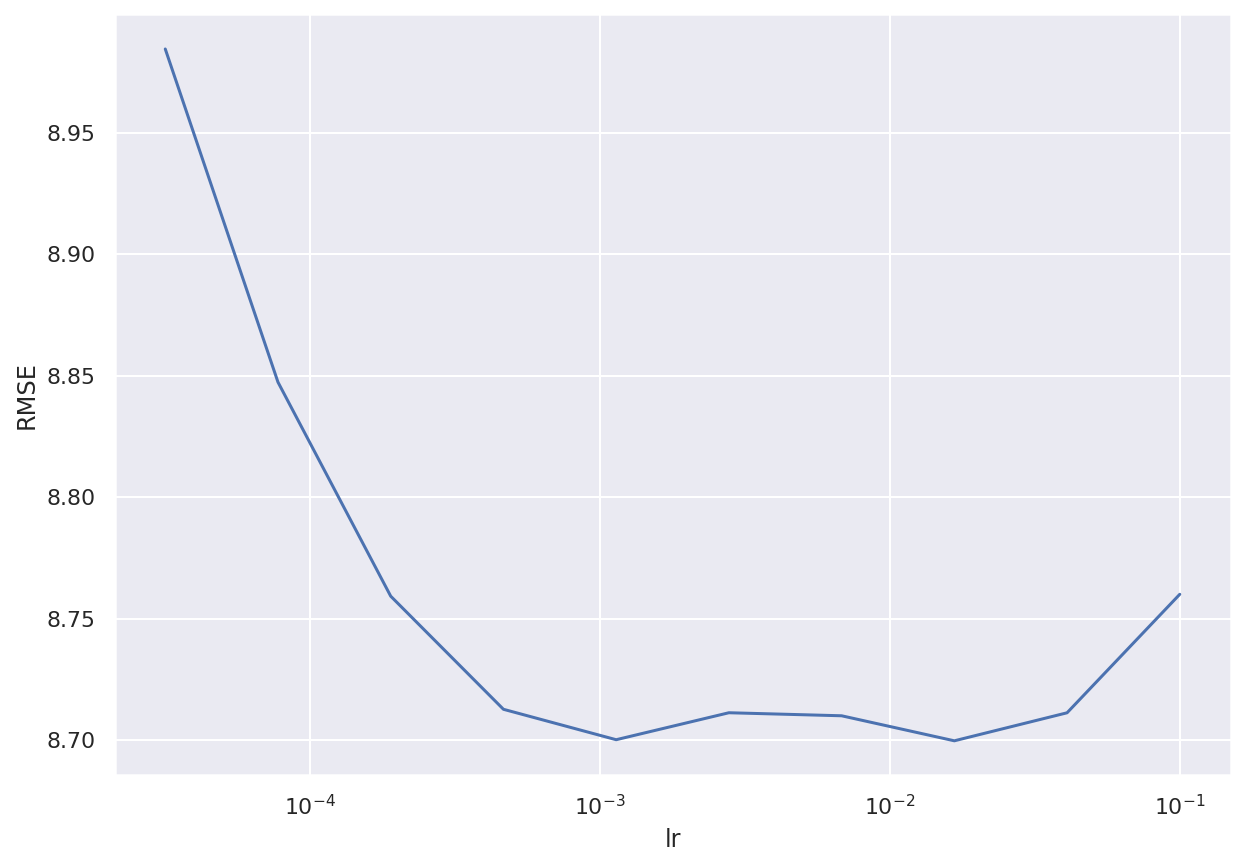

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(lr_s, lr_results)
plt.xscale("log")
plt.xlabel("lr")
plt.ylabel("RMSE");
# best lr1 = 7.74263683e-03
# best lr2 = 1.13646367e-03 / 1.66810054e-02 / 6.81292069e-03

Подберем оптимальное значение gamma -- гиперпараметр для `scheduler` или скорость убывания значения `lr` (в нашем случае, каждые три эпохи).

In [ ]:
print(f'Перебор будет осуществляться по следующему массиву: \n{np.linspace(0.001, 1.5, 10)}')

Перебор будет осуществляться по следующему массиву: 
[1.00000000e-03 1.67555556e-01 3.34111111e-01 5.00666667e-01
 6.67222222e-01 8.33777778e-01 1.00033333e+00 1.16688889e+00
 1.33344444e+00 1.50000000e+00]


In [ ]:
# фиксируем сид
lr_s = np.logspace(-4.5, -1, 10) # в начале был перебор np.logspace(-6, 1, 10)
lr_results = []                  # создаем массив для лосса

Epoch: 15, 
loss_train: 0.8087330460548401, 
loss_test: 0.804828941822052


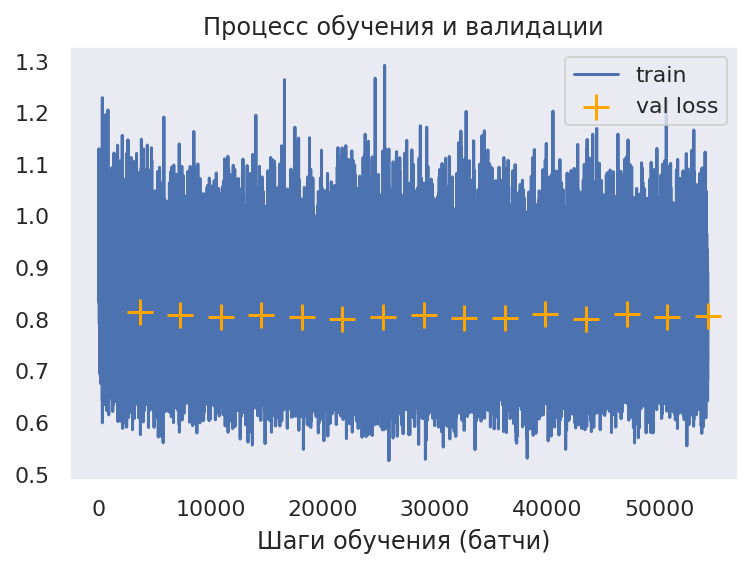

Adjusting learning rate of group 0 to 5.8796e-02.


  0%|          | 0/404 [00:00<?, ?it/s]

In [ ]:
set_random_seed(13)                   # фиксируем сид
gammas = np.linspace(0.001, 1.5, 10)  # создаем массив для gamma
gamma_results = []                    # создаем массив для лосса

for gamma_i in gammas: # итерируемся по разным значениям gamma
    # переопределяем модель для новой инициализации и корректного сравнения
    train_set = MyDataset(X_train_scaled, y_train_scaled)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True)

    test_set = MyDataset(X_test_scaled, y_test_scaled)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, pin_memory=True)

    model = nn.Sequential(
        nn.Linear(90, 220),
        nn.BatchNorm1d(220),
        nn.LeakyReLU(),
        nn.Dropout(0.2),

        nn.Linear(220, 180),
        nn.BatchNorm1d(180),
        nn.LeakyReLU(),
        nn.Dropout(0.25),

        nn.Linear(180, 90),
        nn.BatchNorm1d(90),
        nn.LeakyReLU(),
        nn.Dropout(0.3),

        nn.Linear(90, 60),
        nn.BatchNorm1d(60),
        nn.LeakyReLU(),
        nn.Dropout(0.3),

        nn.Linear(60, 30),
        nn.BatchNorm1d(30),
        nn.Dropout(0.3),
        nn.LeakyReLU(),

        nn.Linear(30, 1)
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=7.74263683e-03) # оптимальный lr, найденный ранее
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=gamma_i, last_epoch=-1, verbose=True) # меняем gamma на каждой итерации цикла
    criterion = nn.MSELoss()
    
    train(model, optimizer, criterion, train_loader, test_loader, device, scheduler, n_epochs=15) # обучаемся на 15 эпохах
    predicts = test(model, criterion, test_loader)

    gamma_results.append(mean_squared_error(scaler.inverse_transform(predicts.reshape(-1, 1)), y_test, squared=False))

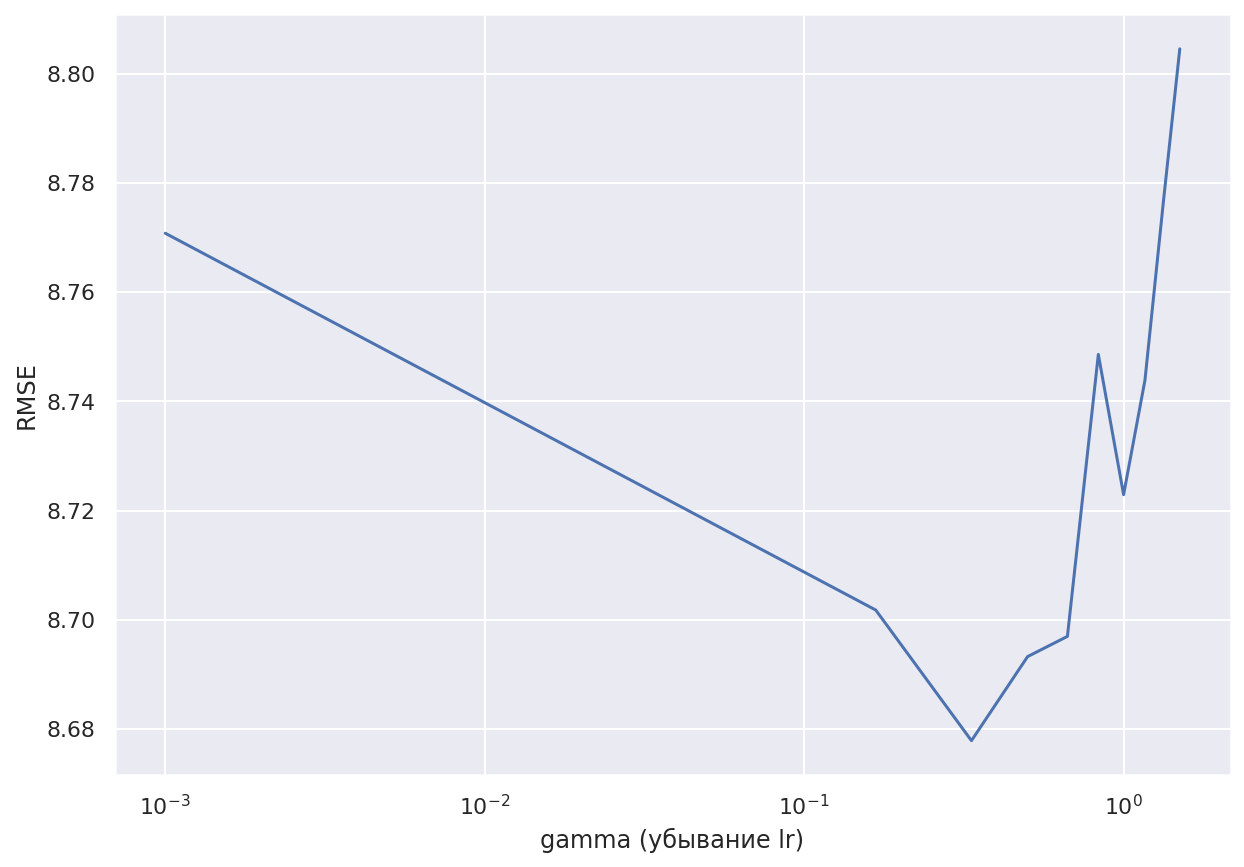

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(gammas, gamma_results)
plt.xscale("log")
plt.xlabel("gamma (убывание lr)")
plt.ylabel("RMSE");
# best gamma = 0.33411111111111114

### Итоговая реализация

Обучимся с хорошим `lr` и `gamma` на 15 эпохах и проверим качество:

Epoch: 15, 
loss_train: 0.7848602533340454, 
loss_test: 0.7935075759887695


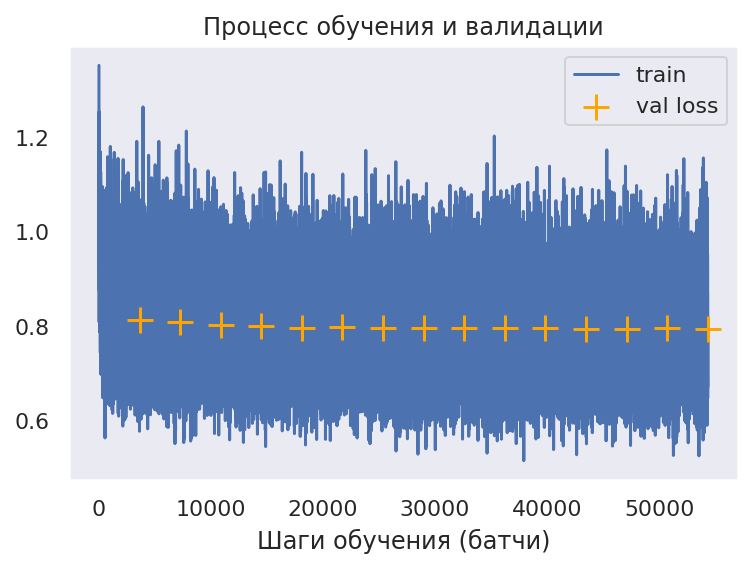

Adjusting learning rate of group 0 to 4.7316e-06.


In [56]:
set_random_seed(13)
train(model, optimizer, criterion, train_loader, test_loader, device, scheduler, n_epochs=15)

Посчитаем предсказанные значения:

In [57]:
# считаем предикты
predicts = test(model, test_loader)

  0%|          | 0/404 [00:00<?, ?it/s]

In [36]:
# проходим тест
assert test(model, test_loader).shape[0] == y_test.shape[0]

  0%|          | 0/404 [00:00<?, ?it/s]

Шкалируем обратно и посчитаем итоговое качество (RMSE):

In [58]:
# считаем RMSE
RMSE = mean_squared_error(
    scaler.inverse_transform(predicts.reshape(-1, 1)),
    y_test,
    squared=False
)

print(f'Наш RMSE составил: {RMSE}')

Наш RMSE составил: 8.680778274384783


---
Ради интереса посмотрим на соотношение предсказанных значений и тестовой выборки для этой модели:

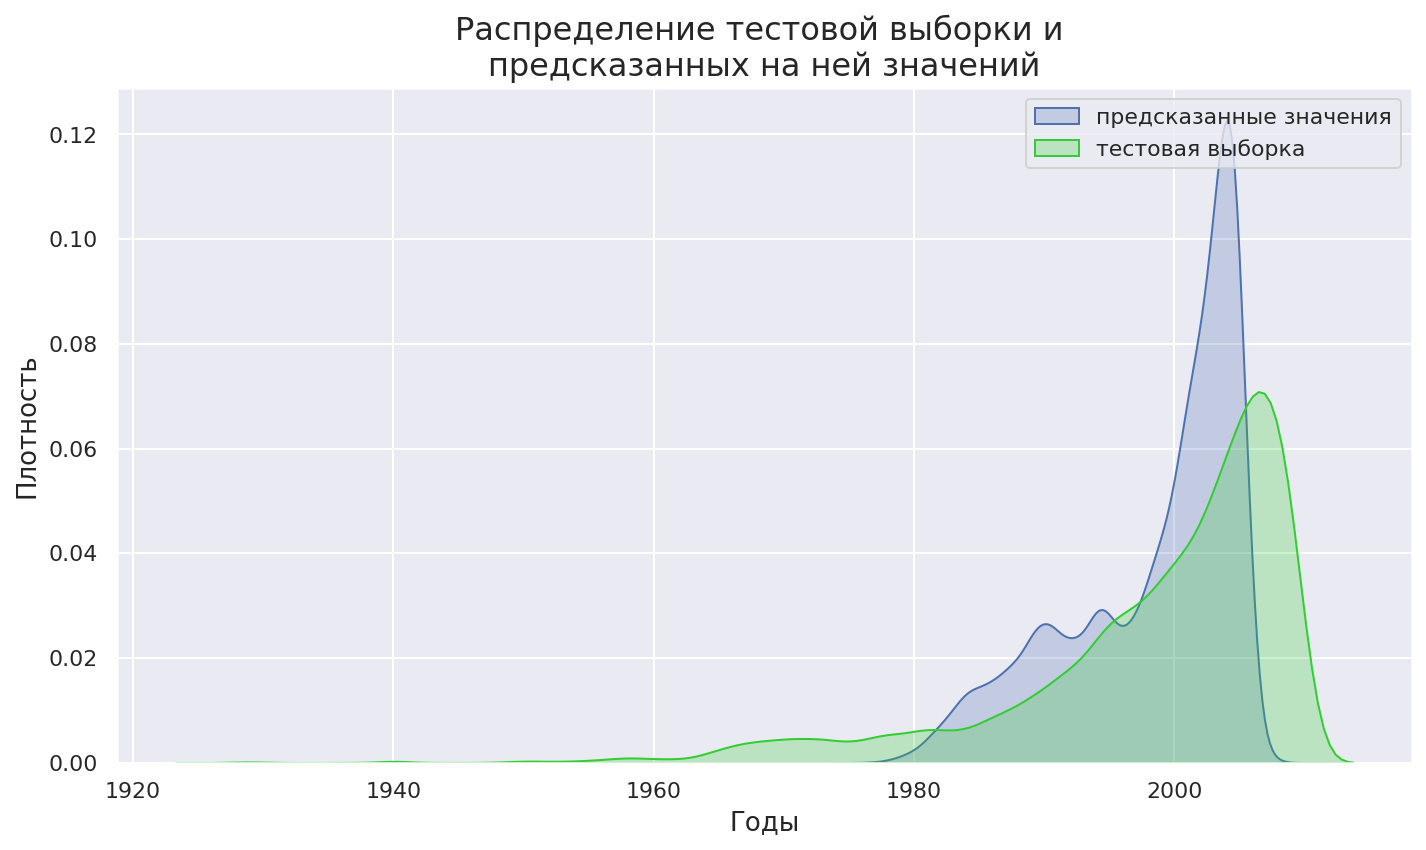

In [59]:
# источник: https://translated.turbopages.org/proxy_u/en-ru.ru.3835a15e-63518d68-de66640a-74722d776562/https/stackoverflow.com/questions/71424546/combine-2-kde-functions-in-one-plot-in-seaborn

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(data=scaler.inverse_transform(predicts.reshape(-1, 1)),
            color='crimson', label='предсказанные значения', fill=True, ax=ax)
sns.kdeplot(data=y_test,
            color='limegreen', label='тестовая выборка', fill=True, ax=ax)
plt.xlabel('Годы', fontsize=13)
plt.ylabel('Плотность', fontsize=13)
plt.title('Распределение тестовой выборки и \nпредсказанных на ней значений', fontsize=16)
ax.legend()
plt.tight_layout()
plt.show()

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

### Исследовательский этап и написание модели

Поскольку изначально я познакомился с эконометрикой, я привык уделять большое внимание исследовательскому этапу работы, с тщательной проработки чего и начал это домашнее задание.

Я потратил много времени на то, чтобы посмотреть на данные под разными углами, понять, как их лучше отмасштабировать, учитывая сильный перекос лет вправо.

Далее я долго колдовал, чтобы все хотя бы как-то запустилось. Долго это не получалось сделать (вылезали разные ошибки), поэтому я решил в начале написать отдельную функцию для одной тренировочной эпохи и валидационной, чтобы потом вставить ее в общую функцию `train()`. Также много проблем было из-за подсчета лосса по эпохе -- с переносом тензоров на cpu для этого.



### Отладка кода

После первого запуска я сделал батчи по 5 объектов, поскольку вся выборка долго считалась, для отладки кода, который периодически вызывал ошибки.

Мой первый запуск: я обучил модель на подвыборке из 100 объектов и 1 слое архитектуры, получил качество 11.8 (здесь и далее, RMSE).

[Здесь](https://wandb.ai/rubanoww/hw-1/reports/mean-val-loss-rmse-22-10-20-18-53-34---VmlldzoyODI1NjM2?accessToken=45tz7n69ckbu54yi2lfvhni14qjvlqqa14l1mjrme14rhsmjbmevh3vap3mfoeaw) можно посмотреть на процесс отладки кода (run whole-aardvark-2). Скачки связаны с перезапуском модели.


### Первые эксперименты

После этого я начал реальные эксперименты с архитектурой.
Для этого мне потребовалось ровно 100 запусков нейросети (не шутка, можно посмотреть по [отчету](https://wandb.ai/rubanoww/hw-1/reports/mean-train-loss-rmse-22-10-20-18-54-07---VmlldzoyODI1NjQ1?accessToken=3rgeq4znj9peygmxp90zemxo9g2dhk9a9jfgt0gqszoaxxadv7tylxcpukrgmsiy)).

На всех объектах обучающей и тестовой выборок первый адекватный лосс составил 10.48, недалеко от константного прогроза средним годом.

Здесь же я попробовал поставить SGD с моментумом и переключился на Collab с локального запуска кода, т.к. ресурсов перестало хватать.

---

Далее я поставил батч, равный 128 объектов и SGD с momentum. 
Архитектура - 3 полносвязных слоя и нелинейности:


```
model = nn.Sequential(
    nn.Linear(90, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
)
```
Лосс составил 11.40 (хуже бейзлайна), неудивительно.

При дальнейших изменениях RMSE долго не менялся, поэтому я выбрал половину выборки для отладки и более кардинальных экспериментов.

---

Добавлен dropout между каждыми слоями, лосс составил 11.33.
Лосс вел себя непонятным образом, колебался. Попробовал увеличить батч, не помогло.

Я добавил несколько полносвязных слоев (до 5) и решил перескейлить данные.

### Дальнейшие эксперименты

Я попробовал прогнать модель с разными техниками нормирования и масштабирования. Результаты:

- `quantile scaler`: 10.85253133719199
- `standard scaler`: 8.750734975884004
- `minmax [0, 1]`: 8.974873726264263
- `minmax [-3, 3]`: 8.8835244368559

До этого использовалось квантильное масштабирование, теперь был выбран `StandardScaler`, показавший лучшую метрику и лучший график обучения в wandb (хорошая аплитуда). 

---

Было замечено, что после 5-й эпохи обучение было не очень большим, поэтому я оставил 5 эпох для ускорения работы.

Сравнил Adam и SGD: последний к 5 эпохе достигал результат Adam-а на 1 эпохе, SGD работал незначительно быстрее, поэтому я выбрал Adam.

Далее я сделал текущую архитектуру нейросети, сделал цикл для перебора порядка `lr`, т.к. модель училась довольно быстро.
Было выяснено, что оптимальный `lr` находится около $10^{-3}$ или даже чуть ближе к $10^{-2}$. Это очень помогло добиться хороших результатов, [отчет](https://wandb.ai/rubanoww/hw-1/reports/mean-val-loss-rmse-22-10-24-21-30-40---VmlldzoyODQ0ODM1?accessToken=h9md04oxawl4utl9u9ccwawhybhpcp8pj2vp5x4w7bnp08khjld951zam34x489v) (run dazzling-lotus-6).

Получился лучший за все время лосс: 8.70045443469277. Это был результат на "десятку", но я чувствовал, что его можно было улучшить.

Дальше перепробовал следующие размеры батча:
- 256: 8.724072581583123
- 64: 8.7163493581044

Оставил 128, как оптимальный, [отчет](https://wandb.ai/rubanoww/hw-1/reports/mean-val-loss-rmse-22-10-24-21-58-56---VmlldzoyODQ0OTc4?accessToken=ja5ctwkfwuk8659yu3s5qe6gsnbwsdpzji35nq1k80bm7qwwe28m0kf1ps3ef6ew) (run dazzling-lotus-6). 


### Финальные штрихи

Поскольку основные момент были подобраны, я решил немного поэксперементировать с архитектурой.

Я немного опустил дропаут (до 0.1 / 0.2 с 0.2 / 0.3), лосс стал больше: 8.711274539184677.

Далее я менял некоторые тонкости в архиетктуре (число выходных и входных параметров в некоторых полносвязных слоях), я бы назвал это «танцем вокруг оптимума», [отчет](https://wandb.ai/rubanoww/hw-1/reports/mean-val-loss-rmse-22-10-24-22-58-56---VmlldzoyODQ1MjQx?accessToken=t1bh0pd25ria8so1ab5htvsvo2u2y5hko88aqbnfos759s4h0382mdgwmr6wyj8o) (run earnest-sponge-7).
Резкие скачки вверх объясняются новой инициализацией весов.

После этого я добавил 6-й полносвязный слой и получил почти лучший вариант 8.705769633668972. Но по графику обучения я видел, что у 6 слоев есть перспектива для улучшения.

В результате я остановился на следующей архитектуре:



```
model = nn.Sequential(
    nn.Linear(90, 220),
    nn.BatchNorm1d(220),
    nn.LeakyReLU(),
    nn.Dropout(0.2),

    nn.Linear(220, 180),
    nn.BatchNorm1d(180),
    nn.LeakyReLU(),
    nn.Dropout(0.25),

    nn.Linear(180, 90),
    nn.BatchNorm1d(90),
    nn.LeakyReLU(),
    nn.Dropout(0.3),

    nn.Linear(90, 60),
    nn.BatchNorm1d(60),
    nn.LeakyReLU(),
    nn.Dropout(0.3),

    nn.Linear(60, 30),
    nn.BatchNorm1d(30),
    nn.Dropout(0.3),
    nn.LeakyReLU(),

    nn.Linear(30, 1)
)
```






Далее я столкнулся с **переобучением**, [трейн](https://wandb.ai/rubanoww/hw-1/reports/mean-train-loss-rmse-22-10-24-23-42-24---VmlldzoyODQ1NDE2?accessToken=oy7gbkjvdxsu0dm3i5pl2h3t4dqe7l7px8o51uq9cr7gpwlmknhojjuq1zvqzj3e) и [тест](https://wandb.ai/rubanoww/hw-1/reports/mean-val-loss-rmse-22-10-24-23-42-42---VmlldzoyODQ1NDE5?accessToken=ll33tmhfl3h8ghm0ww4aj95du36b0596kbix1e47swk1gebt6qbp93b6zgcuxg1m) (run dazzling-lotus-6 и earnest-sponge-7).

После этого я подтянул дропаут, поставил `LeakyReLU` вместо обычного `ReLU`. Также я вставил `scheduler`, модель стала очень быстро обучаться (лосс быстро спускался), но в конце лосс поднимался. Я попробовал выставить следующие гиперпараметры `gamma` (коэффициент снижения `lr`):
- `gamma=0.3`: 8.715806213249552 
- `gamma=0.5`: 8.705408986711033

Эксперименты со скоростью убывания `lr`: [отчет 1](https://wandb.ai/rubanoww/hw-1/reports/mean-val-loss-rmse-22-10-25-00-55-04---VmlldzoyODQ1NzA4?accessToken=oj4zizcn9abg14y1zp2int0fpk6vamsw3tff8kwovo9z1kepr1c520kn5uowqd27), [отчет 2](https://wandb.ai/rubanoww/hw-1/reports/mean-val-loss-rmse-22-10-25-01-37-35---VmlldzoyODQ1ODU0?accessToken=175y9f84rxozvw9e1t0gf1dn02jrkye04zb8eebvq6sgyqu0g0iituik3ojgq21q) (run dazzling-lotus-6). 

Был достигнут неплохой результат, судя по графикам.
 





### Финальная версия

В финале я решил перебрать коэффициет затухания `lr`, т.к. обучение "штормило" ближе к концу. 

Я перебрал np.linspace(0.001, 1.5, 10) в качестве `gamma`: [отчет](https://wandb.ai/rubanoww/hw-1/reports/mean-val-loss-rmse-22-10-25-22-53-25---VmlldzoyODUyMDY5?accessToken=heutzvkzoo2favs7im12epwl7p9geb32ycqm1mxo30rgsmkaa07l20hjtr0t1ywf) (run
earnest-spaceship-10).
 
Потом я еще раз перебрал стартовое значение `lr` по np.logspace(-4.5, -1, 10): [отчет](https://wandb.ai/rubanoww/hw-1/reports/mean-val-loss-rmse-22-10-25-23-45-51---VmlldzoyODUyMjU2?accessToken=4s4qo9hux3sg2caaqghaelhh8m1e4qhpeqd6b31ua1mcoe9a45a3kkov8ndzo5db) (run
earnest-spaceship-10)
 
Я отобрал лучшие значения `lr` и произвел финальный замер, были обновлены лучшие результаты: 

- `lr=1.66810054e-02`: 8.69874211592728, *новый рекорд*
- `lr= 1.13646367e-03`: 8.80778274384783, *новый рекорд*
- `lr= 6.81292069e-03`: 8.713821580117612
- `lr= 7.74263683e-03`: 8.720568347682192

Финальный отчет: [ссылка](https://wandb.ai/rubanoww/hw-1/reports/mean-val-loss-rmse-22-10-26-00-38-32---VmlldzoyODUyNDIz?accessToken=x0en2j6axojv5swbas01ohaug5mq9b9poko5nce93syftflpye1bhfleb8xr6x21) (run earnest-spaceship-10).

Также потом я еще раз проверил указанную модель, [отчет](https://wandb.ai/rubanoww/hw-1/reports/mean-val-loss-rmse-22-10-26-21-44-53---VmlldzoyODU4NTc0?accessToken=299829en6y3jvek0544s6k844fa5mc4kpodytp62nlejnrsrdw94wqkm8utjozoa) (run lemon-capybara-12). Снова был получен **loss 8.680778274384783**.



 
